<a href="https://colab.research.google.com/github/OnyedikachiOnwuachuke/Stock-Price-Prediction-Using-Sentiment-Analysis/blob/main/PREDICTING_TESLA_STOCK_PRICE_USING_SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**IMPORT LIBRARIES**

In [44]:
# Importing necessary libraries
!pip install yfinance
import yfinance as yf
import os
from google.colab import drive
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose

# For Sentiment data analysis
!pip install transformers
import re
import nltk
from nltk.corpus import stopwords
from sklearn.pipeline import make_pipeline
from transformers import pipeline

# For machine learning models
!pip install bayesian-optimization
!pip install keras-tuner
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
import keras_tuner as kt

# For time series models
from statsmodels.tsa.arima.model import ARIMA


# For LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

###**STOCK DATA**

In [45]:
# Loading the stock price data from yahoo finance with the company ticker
TSLA = yf.Ticker("TSLA")
end_date = "2022-09-30"
# All the information about the the comapany ( Tesla Inc.)
TSLA.info

{'address1': '1 Tesla Road',
 'city': 'Austin',
 'state': 'TX',
 'zip': '78725',
 'country': 'United States',
 'phone': '512 516 8177',
 'website': 'https://www.tesla.com',
 'industry': 'Auto Manufacturers',
 'industryKey': 'auto-manufacturers',
 'industryDisp': 'Auto Manufacturers',
 'sector': 'Consumer Cyclical',
 'sectorKey': 'consumer-cyclical',
 'sectorDisp': 'Consumer Cyclical',
 'longBusinessSummary': 'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits; and non-warranty after-sales vehicle, used vehicles, body shop and parts, supercharging, retail merchandise, and vehicle insurance services. This segment also provides sedans and sport utility vehicles through direct and used vehic

In [46]:
# To display, describe and give the necessary information about the stock data
original_stock_data = TSLA.history(period="max", end=end_date)
original_stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [47]:
# Check the data structure and summary of the stock data
print("Data Info:")
print(original_stock_data.info())

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3086 entries, 2010-06-29 00:00:00-04:00 to 2022-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3086 non-null   float64
 1   High          3086 non-null   float64
 2   Low           3086 non-null   float64
 3   Close         3086 non-null   float64
 4   Volume        3086 non-null   int64  
 5   Dividends     3086 non-null   float64
 6   Stock Splits  3086 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 192.9 KB
None


In [48]:
# Display basic statistical details of the stock data
print("\nStatistical Summary:")
print(original_stock_data.describe())



Statistical Summary:
              Open         High          Low        Close        Volume  \
count  3086.000000  3086.000000  3086.000000  3086.000000  3.086000e+03   
mean     56.092391    57.347290    54.734650    56.075755  9.338840e+07   
std      94.538287    96.712675    92.122923    94.452346  8.232205e+07   
min       1.076000     1.108667     0.998667     1.053333  1.777500e+06   
25%       8.226167     8.375334     7.978500     8.142833  4.172138e+07   
50%      16.000000    16.257999    15.709667    16.008666  7.537575e+07   
75%      23.637500    23.983333    23.313667    23.635166  1.172816e+08   
max     411.470001   414.496674   405.666656   409.970001  9.140820e+08   

       Dividends  Stock Splits  
count     3086.0   3086.000000  
mean         0.0      0.002592  
std          0.0      0.104949  
min          0.0      0.000000  
25%          0.0      0.000000  
50%          0.0      0.000000  
75%          0.0      0.000000  
max          0.0      5.000000  


In [49]:
# Check for missing values on the stock data
print("\nMissing Values:")
print(original_stock_data.isnull().sum())



Missing Values:
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [50]:
# Display the shape of the stock data
print("\nShape of the Data:")
print(original_stock_data.shape)


Shape of the Data:
(3086, 7)


In [51]:
#Drop the unnecssary columns for visualisations
original_stock_data = original_stock_data.drop(columns=['Volume', 'Dividends', 'Stock Splits'])
original_stock_data.head()


,Open,High,Low,Close
Date,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000


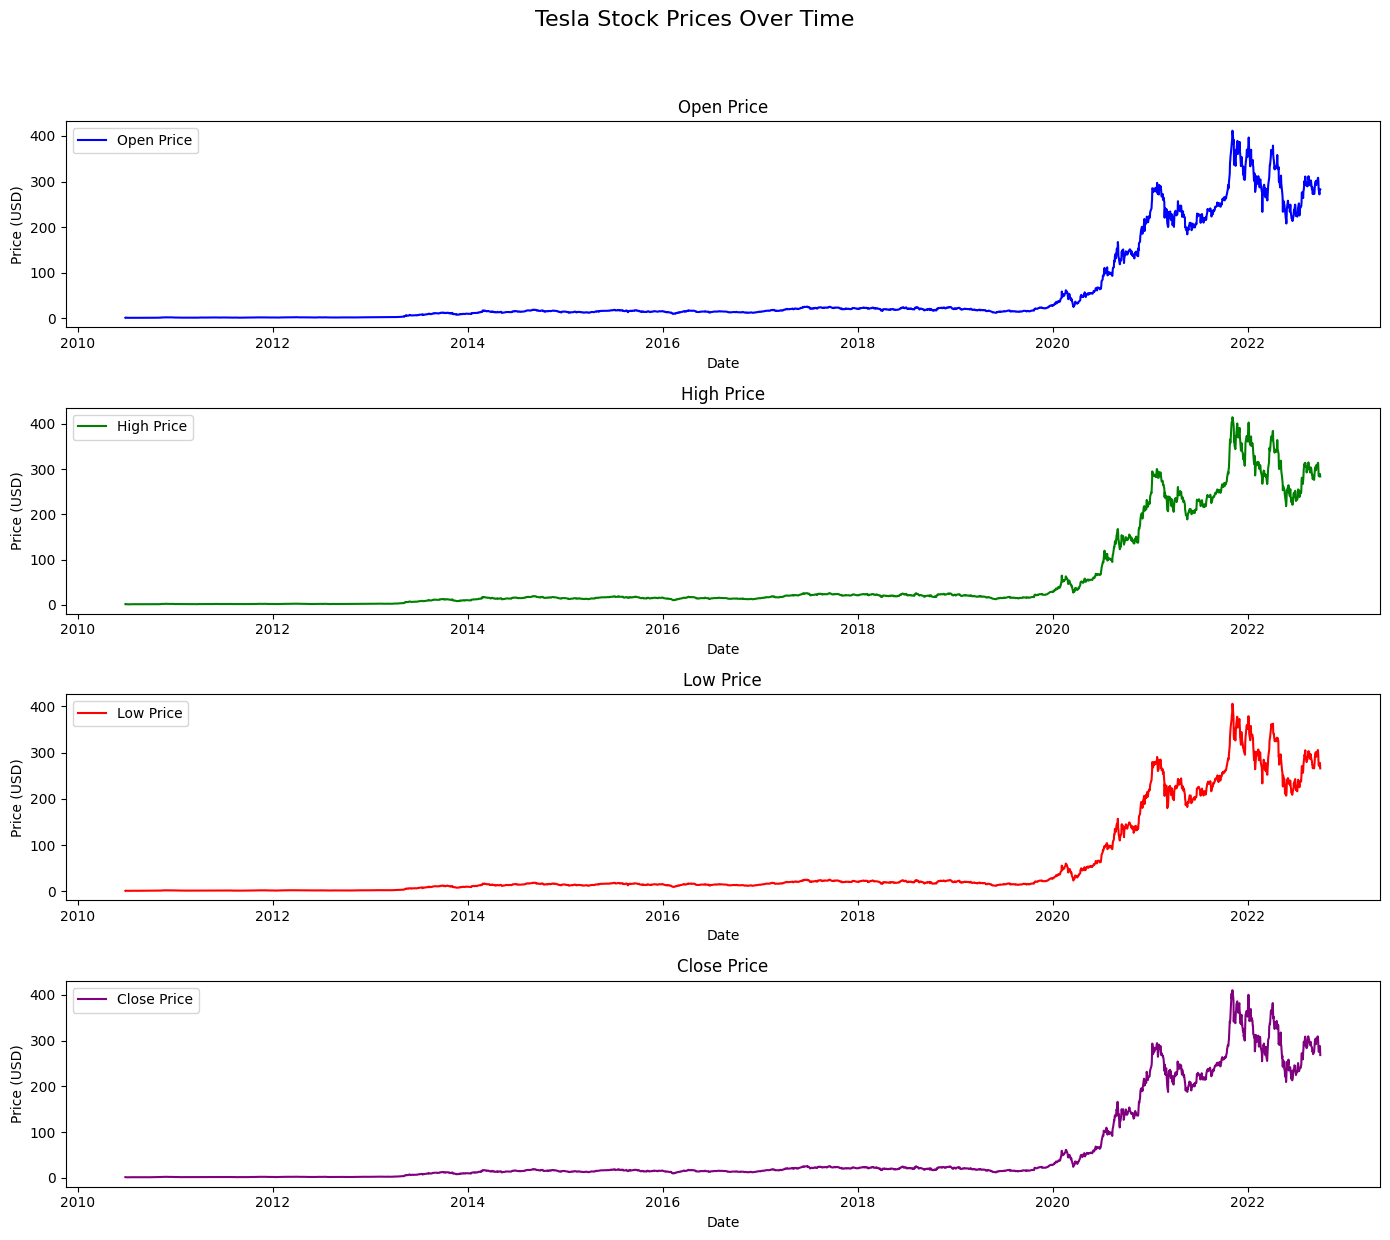

In [52]:
# Creating a 4x1 subplot for Open, High, Low, and Close prices without sharing the x-axis
fig, axs = plt.subplots(4, 1, figsize=(14, 13))
fig.suptitle('Tesla Stock Prices Over Time', fontsize=16)

# Plotting each price type in a separate subplot without shared x-axes
# 1. Open Price
axs[0].plot(original_stock_data.index, original_stock_data['Open'], label='Open Price', color='blue')
axs[0].set_title('Open Price')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price (USD)')
axs[0].legend()

# 2. High Price
axs[1].plot(original_stock_data.index, original_stock_data['High'], label='High Price',color='green')
axs[1].set_title('High Price')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price (USD)')
axs[1].legend()


# 3. Low Price
axs[2].plot(original_stock_data.index, original_stock_data['Low'], label='Low Price', color='red')
axs[2].set_title('Low Price')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price (USD)')
axs[2].legend()

# 4. Close Price
axs[3].plot(original_stock_data.index, original_stock_data['Close'], label='Close Price',color='purple')
axs[3].set_title('Close Price')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Price (USD)')
axs[3].legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


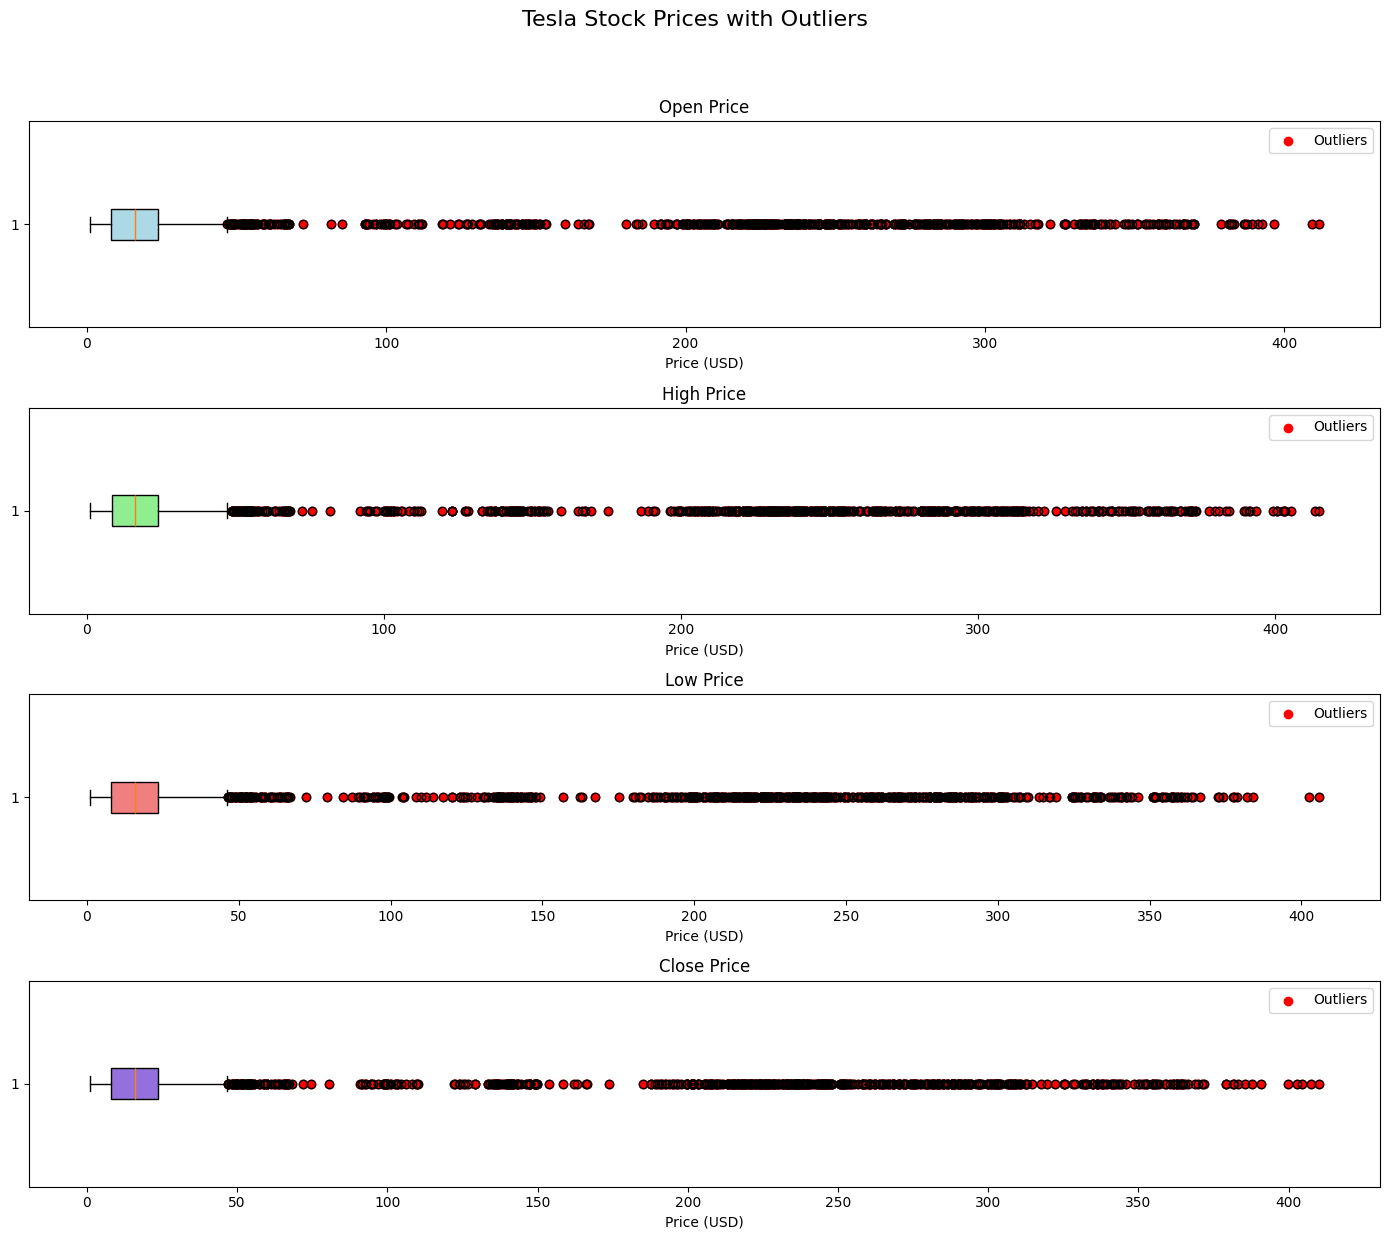

In [53]:
# Using the stock_data DataFrame with 'Open', 'High', 'Low', and 'Close' columns
data_column = original_stock_data[['Open', 'High', 'Low', 'Close']]

# Create a 4x1 subplot grid
fig, axs = plt.subplots(4, 1, figsize=(14, 13))
fig.suptitle('Tesla Stock Prices with Outliers', fontsize=16)

# Function to calculate outliers and plot boxplot with highlighting
def plot_box_with_outliers(data, ax, label, color):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    # Plot boxplot
    ax.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor=color))
    ax.scatter(outliers, [1] * len(outliers), color='red', label='Outliers', marker='o')

    ax.set_title(label)
    ax.set_xlabel('Price (USD)')
    ax.legend()

# Plot each price type with outliers
plot_box_with_outliers(original_stock_data['Open'], axs[0], 'Open Price', 'lightblue')
plot_box_with_outliers(original_stock_data['High'], axs[1], 'High Price', 'lightgreen')
plot_box_with_outliers(original_stock_data['Low'], axs[2], 'Low Price', 'lightcoral')
plot_box_with_outliers(original_stock_data['Close'], axs[3], 'Close Price', 'mediumpurple')  # Updated color

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


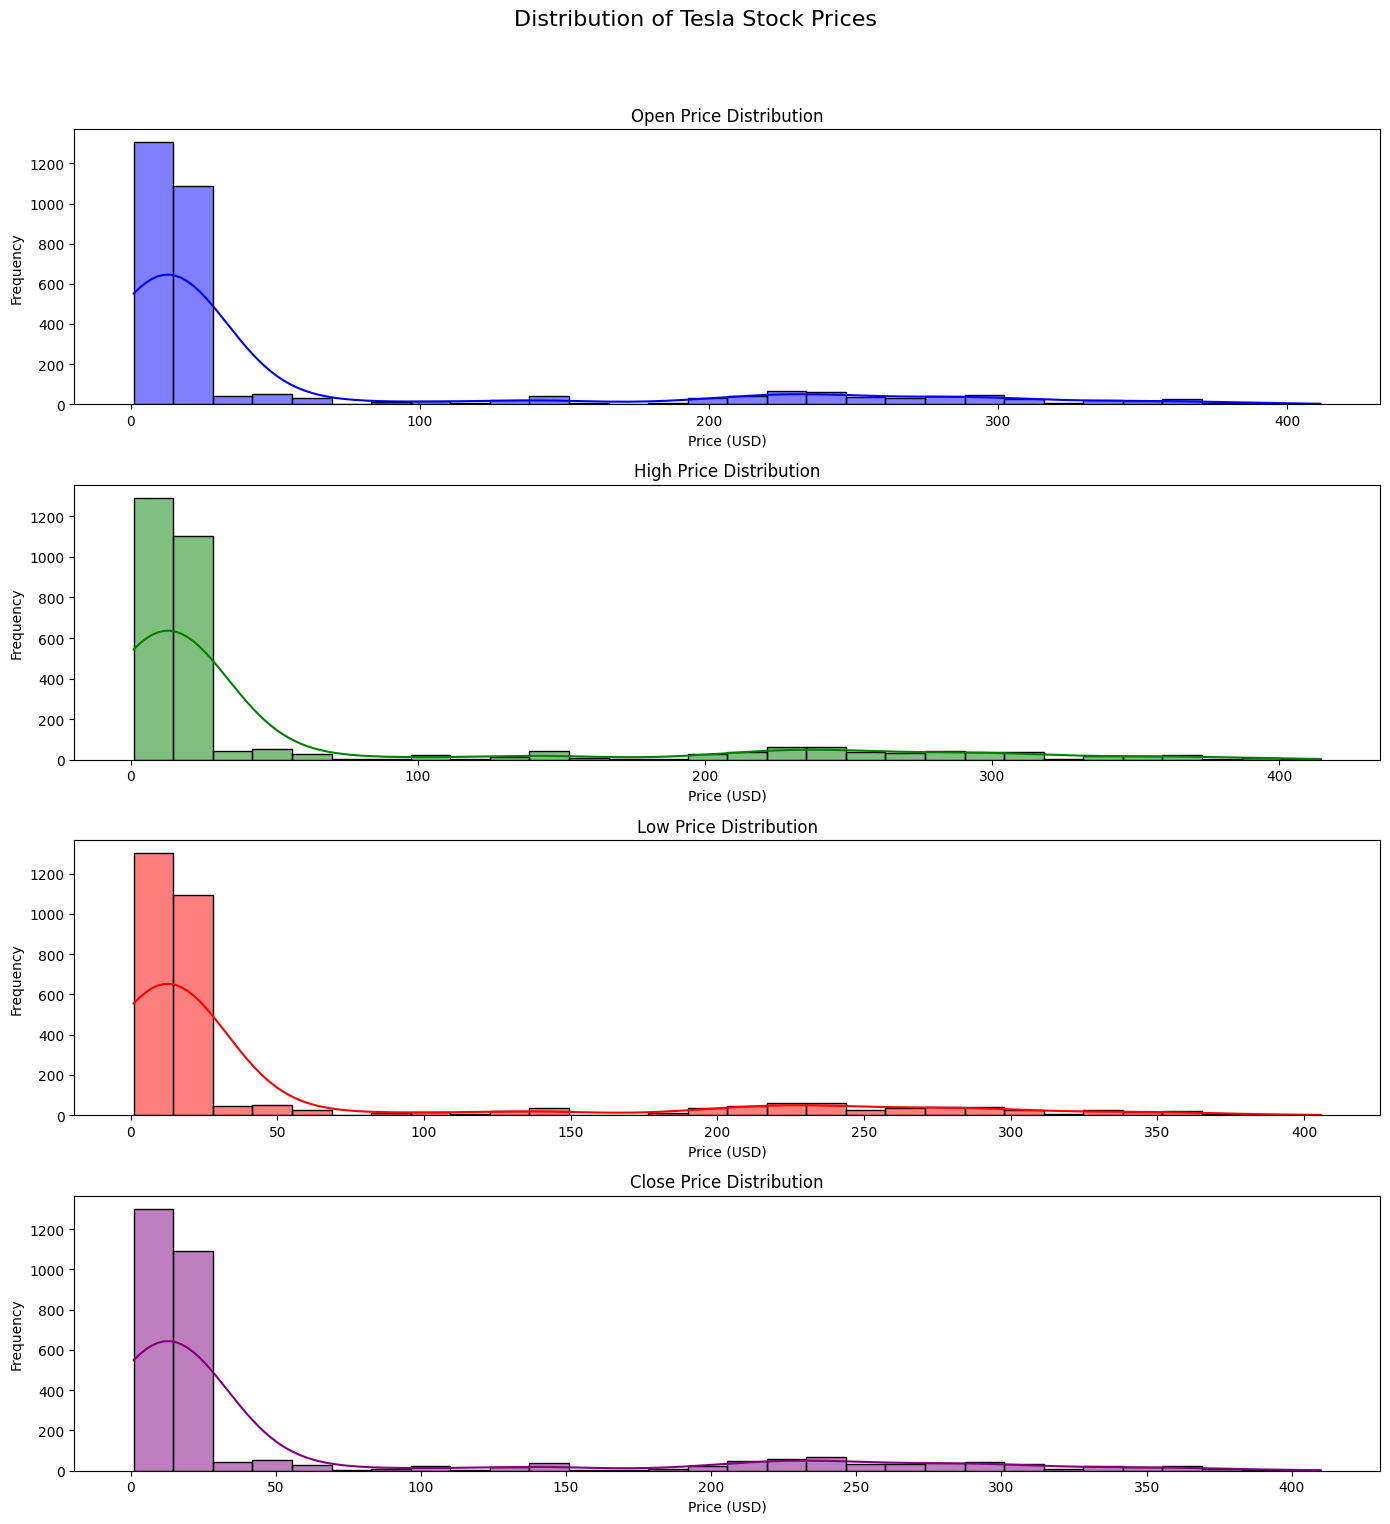

In [54]:
# Creating a 4x1 subplot for Open, High, Low, and Close price distributions
fig, axs = plt.subplots(4, 1, figsize=(14, 16))
fig.suptitle('Distribution of Tesla Stock Prices', fontsize=16)

# Plotting each price type as a histogram
# 1. Open Price Distribution
sns.histplot(original_stock_data['Open'], bins=30, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Open Price Distribution')
axs[0].set_xlabel('Price (USD)')
axs[0].set_ylabel('Frequency')

# 2. High Price Distribution
sns.histplot(original_stock_data['High'], bins=30, kde=True, color='green', ax=axs[1])
axs[1].set_title('High Price Distribution')
axs[1].set_xlabel('Price (USD)')
axs[1].set_ylabel('Frequency')

# 3. Low Price Distribution
sns.histplot(original_stock_data['Low'], bins=30, kde=True, color='red', ax=axs[2])
axs[2].set_title('Low Price Distribution')
axs[2].set_xlabel('Price (USD)')
axs[2].set_ylabel('Frequency')

# 4. Close Price Distribution
sns.histplot(original_stock_data['Close'], bins=30, kde=True, color='purple', ax=axs[3])
axs[3].set_title('Close Price Distribution')
axs[3].set_xlabel('Price (USD)')
axs[3].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


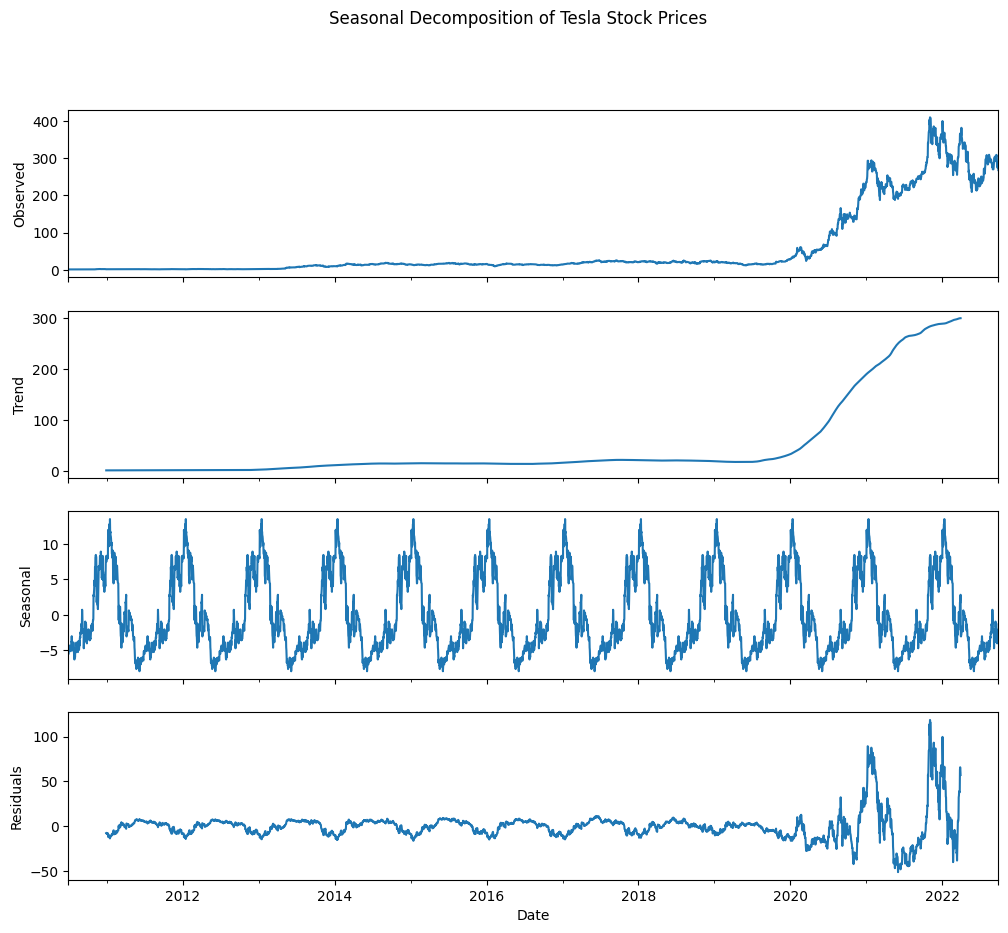

In [55]:
# The stock data is in daily frequency to ensure even time intervals
stock_data_daily = original_stock_data['Close'].resample('D').ffill()

# Perform seasonal decomposition on the 'Close' prices
decomposition = seasonal_decompose(stock_data_daily, model='additive', period=365)  # period=365 for daily data

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Seasonal Decomposition of Tesla Stock Prices')

decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residuals')
axes[3].set_xlabel('Date')

plt.show()

In [56]:
# Calculate Simple Moving Average (SMA) using the calculate_ma function
def calculate_ma(df, window):
    """
    Calculate the Simple Moving Average (MA/SMA) over a specified window.
    """
    return df['Close'].rolling(window=window).mean()

# Calculate 20-day and 50-day Moving Averages (MAs or SMAs)
original_stock_data['SMA_20'] = calculate_ma(original_stock_data, window=20)
original_stock_data['SMA_50'] = calculate_ma(original_stock_data, window=50)

# Exponential Moving Average (EMA)
def calculate_ema(df, span):
    """
    Calculate the Exponential Moving Average (EMA).
    """
    return df['Close'].ewm(span=span, adjust=False).mean()

# Calculate EMA 50 and EMA 200
original_stock_data['EMA_50'] = calculate_ema(original_stock_data, span=50)
original_stock_data['EMA_200'] = calculate_ema(original_stock_data, span=200)

# Moving Average Convergence/Divergence (MACD)
def calculate_macd(df, short_span=12, long_span=26, signal_span=9):
    """
    Calculate the MACD, Signal Line, and MACD Histogram.
    """
    short_ema = df['Close'].ewm(span=short_span, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_span, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_span, adjust=False).mean()
    macd_histogram = macd - signal
    return pd.DataFrame({'MACD': macd, 'Signal': signal, 'MACD_Histogram': macd_histogram})

# Calculate MACD, Signal Line, and MACD Histogram
macd_df = calculate_macd(original_stock_data)

# Add MACD components to the DataFrame
original_stock_data['MACD'] = macd_df['MACD']
original_stock_data['MACD_Signal'] = macd_df['Signal']
original_stock_data['MACD_Histogram'] = macd_df['MACD_Histogram']

# Relative Strength Index (RSI)
def calculate_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI
original_stock_data['RSI'] = calculate_rsi(original_stock_data)

# Average Directional Index (ADX)
def calculate_adx(df, window=14):
    high = df['High']
    low = df['Low']
    close = df['Close']

    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    atr = tr.rolling(window=window, min_periods=1).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/window).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/window).mean() / atr))

    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.ewm(alpha=1/window).mean()

    return pd.DataFrame({'ADX': adx, 'Plus_DI': plus_di, 'Minus_DI': minus_di})

# Calculate ADX, Plus_DI, and Minus_DI
adx_df = calculate_adx(original_stock_data)

# Add ADX components to the DataFrame
original_stock_data['ADX'] = adx_df['ADX']
original_stock_data['Plus_DI'] = adx_df['Plus_DI']
original_stock_data['Minus_DI'] = adx_df['Minus_DI']

# Drop rows with NaN values at the beginning of the dataset (if any)
original_stock_data.dropna(inplace=True)

# Display the first few rows of the updated DataFrame
stock_data = original_stock_data

stock_data.head()

,Open,High,Low,Close,SMA_20,SMA_50,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
Date,,,,,,,,,,,,,,,
2010-09-08 00:00:00-04:00,1.377333,1.396667,1.373333,1.393333,1.301467,1.322240,1.361035,1.486359,0.013624,-0.001767,0.015391,67.149673,15.148664,32.092516,19.425309
2010-09-09 00:00:00-04:00,1.400000,1.403333,1.379333,1.380667,1.310833,1.318000,1.361805,1.485307,0.015075,0.001602,0.013474,65.047002,15.941895,32.222275,18.931977
2010-09-10 00:00:00-04:00,1.383333,1.395333,1.317333,1.344667,1.319400,1.313120,1.361133,1.483908,0.013169,0.003915,0.009254,58.093849,15.238047,28.376171,25.006138
2010-09-13 00:00:00-04:00,1.392667,1.393333,1.366667,1.381333,1.327400,1.311467,1.361925,1.482887,0.014450,0.006022,0.008428,54.812352,14.586735,27.918925,24.603195
2010-09-14 00:00:00-04:00,1.369333,1.440000,1.368667,1.408000,1.335200,1.314027,1.363732,1.482142,0.017416,0.008301,0.009115,67.142833,14.802616,32.856891,23.046153


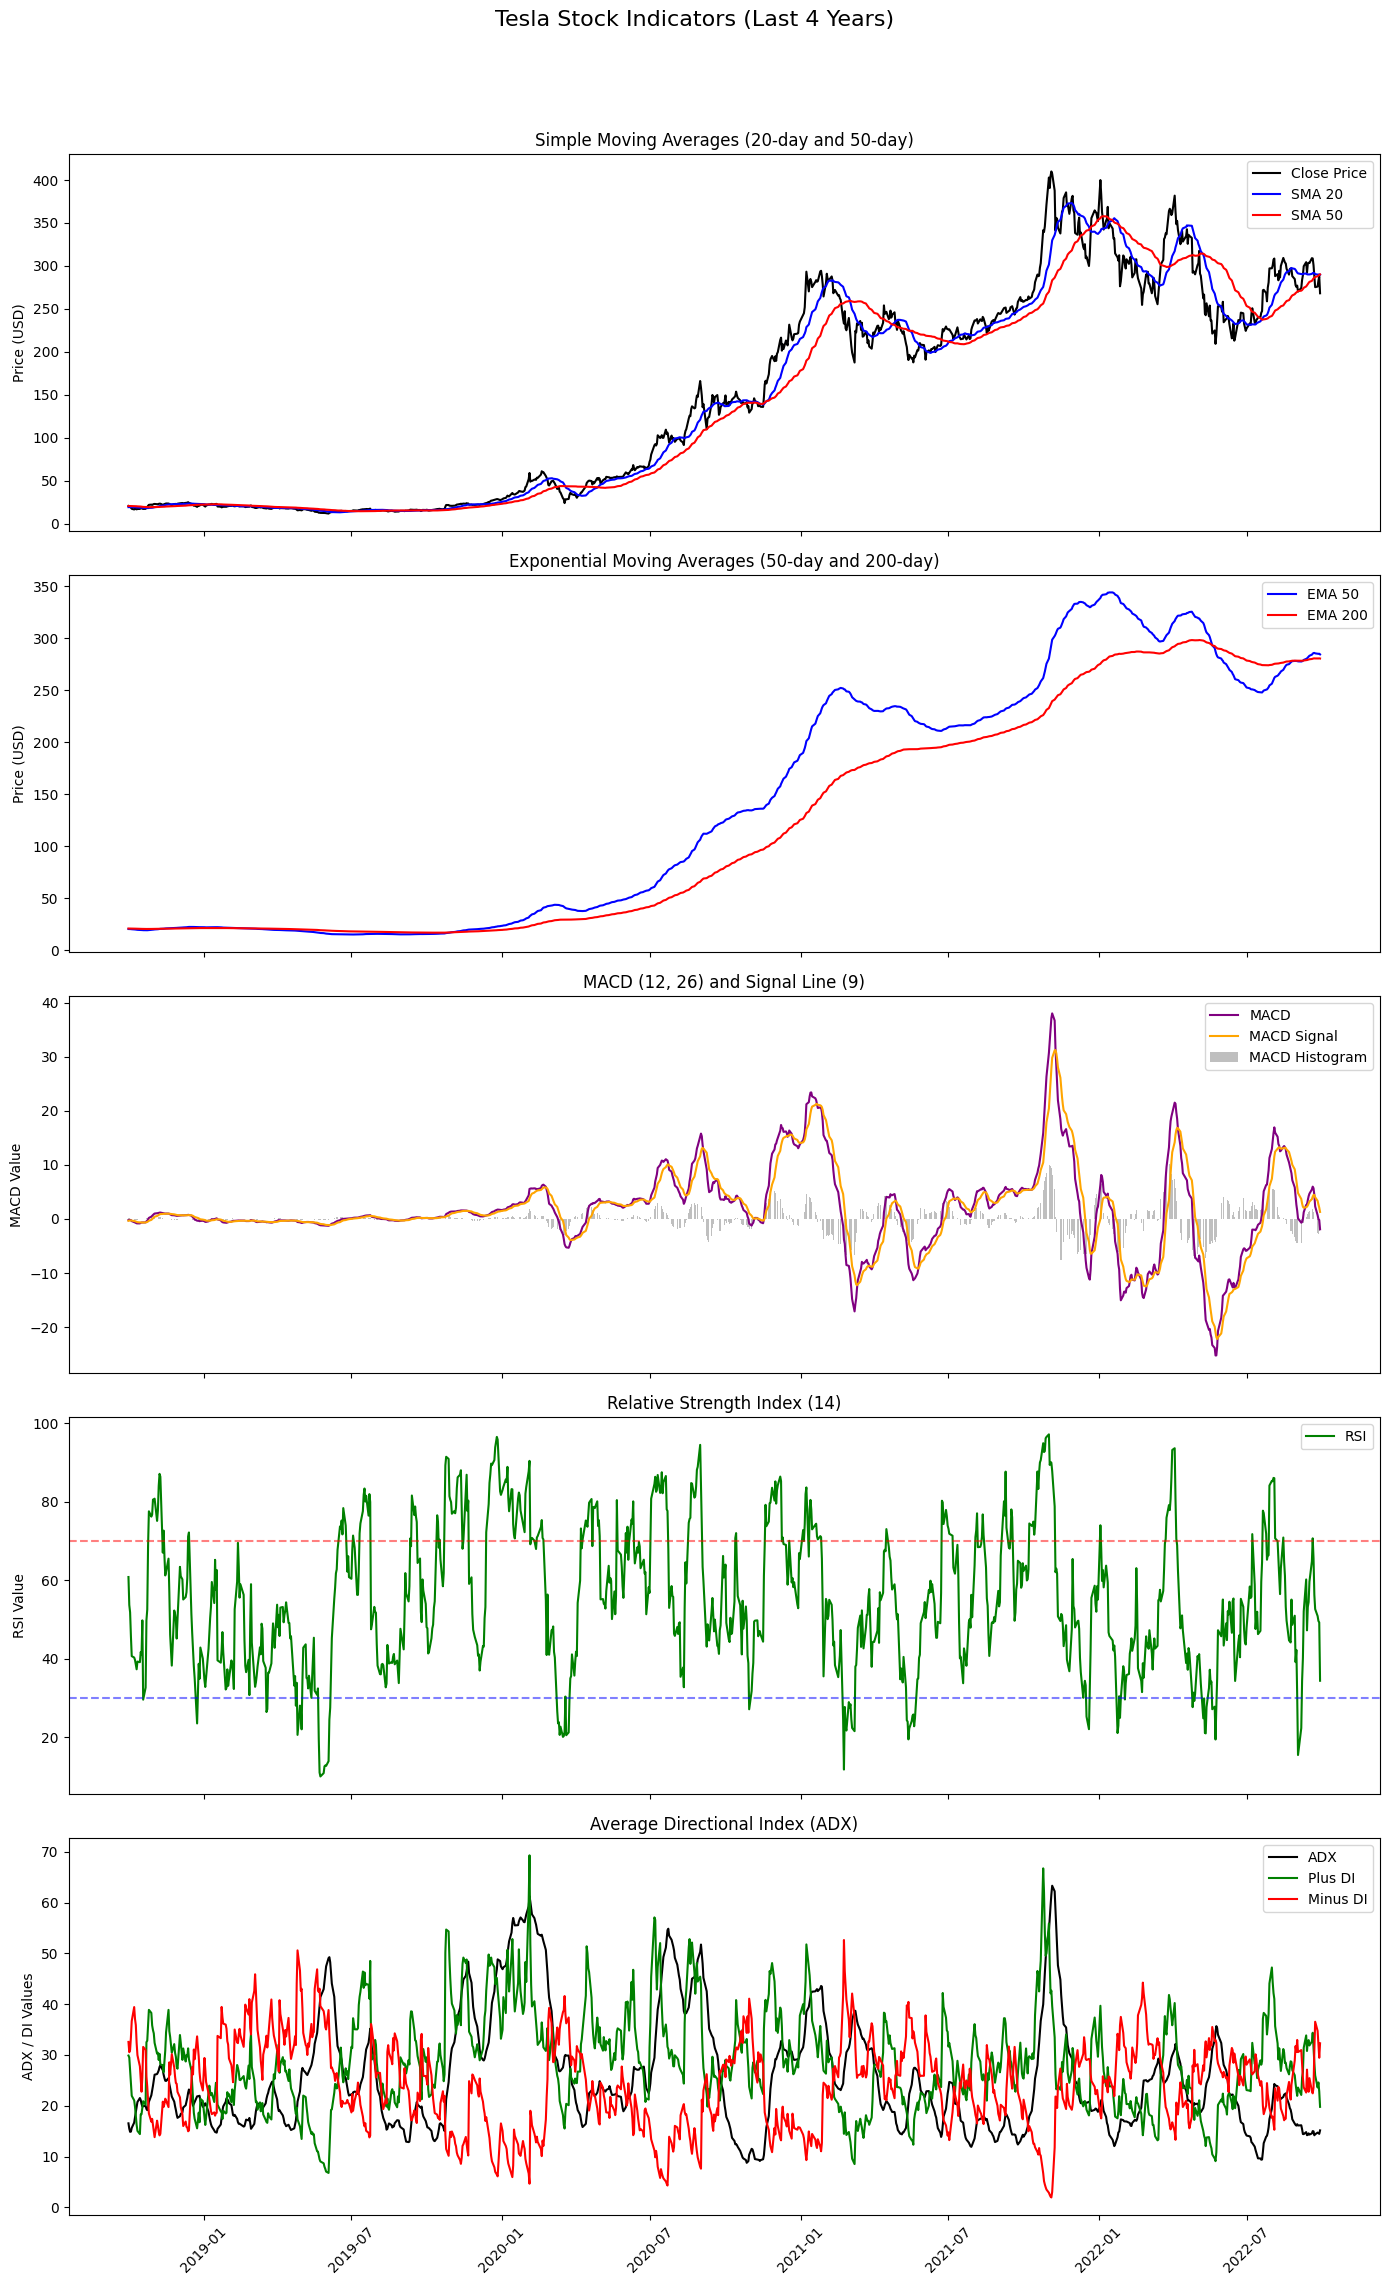

In [57]:
# Filtering the data for the last four years for visualising the necessary indicators
four_years_ago = stock_data.index.max() - timedelta(days=4*365)
filtered_data = stock_data[stock_data.index >= four_years_ago]

# Plot the indicators for the filtered data
fig, axs = plt.subplots(5, 1, figsize=(14, 24), sharex=True)
fig.suptitle('Tesla Stock Indicators (Last 4 Years)', fontsize=16)

# Plot SMAs and Closing Price
axs[0].plot(filtered_data.index, filtered_data['Close'], label='Close Price', color='black')
axs[0].plot(filtered_data.index, filtered_data['SMA_20'], label='SMA 20', color='blue')
axs[0].plot(filtered_data.index, filtered_data['SMA_50'], label='SMA 50', color='red')
axs[0].set_ylabel('Price (USD)')
axs[0].set_title('Simple Moving Averages (20-day and 50-day)')
axs[0].legend()

# Plot EMAs
axs[1].plot(filtered_data.index, filtered_data['EMA_50'], label='EMA 50', color='blue')
axs[1].plot(filtered_data.index, filtered_data['EMA_200'], label='EMA 200', color='red')
axs[1].set_ylabel('Price (USD)')
axs[1].set_title('Exponential Moving Averages (50-day and 200-day)')
axs[1].legend()

# Plot MACD
axs[2].plot(filtered_data.index, filtered_data['MACD'], label='MACD', color='purple')
axs[2].plot(filtered_data.index, filtered_data['MACD_Signal'], label='MACD Signal', color='orange')
axs[2].bar(filtered_data.index, filtered_data['MACD_Histogram'], label='MACD Histogram', color='grey', alpha=0.5)
axs[2].set_ylabel('MACD Value')
axs[2].set_title('MACD (12, 26) and Signal Line (9)')
axs[2].legend()

# Plot RSI
axs[3].plot(filtered_data.index, filtered_data['RSI'], label='RSI', color='green')
axs[3].axhline(70, linestyle='--', color='red', alpha=0.5)
axs[3].axhline(30, linestyle='--', color='blue', alpha=0.5)
axs[3].set_ylabel('RSI Value')
axs[3].set_title('Relative Strength Index (14)')
axs[3].legend()

# Plot ADX
axs[4].plot(filtered_data.index, filtered_data['ADX'], label='ADX', color='black')
axs[4].plot(filtered_data.index, filtered_data['Plus_DI'], label='Plus DI', color='green')
axs[4].plot(filtered_data.index, filtered_data['Minus_DI'], label='Minus DI', color='red')
axs[4].set_ylabel('ADX / DI Values')
axs[4].set_title('Average Directional Index (ADX)')
axs[4].legend()

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


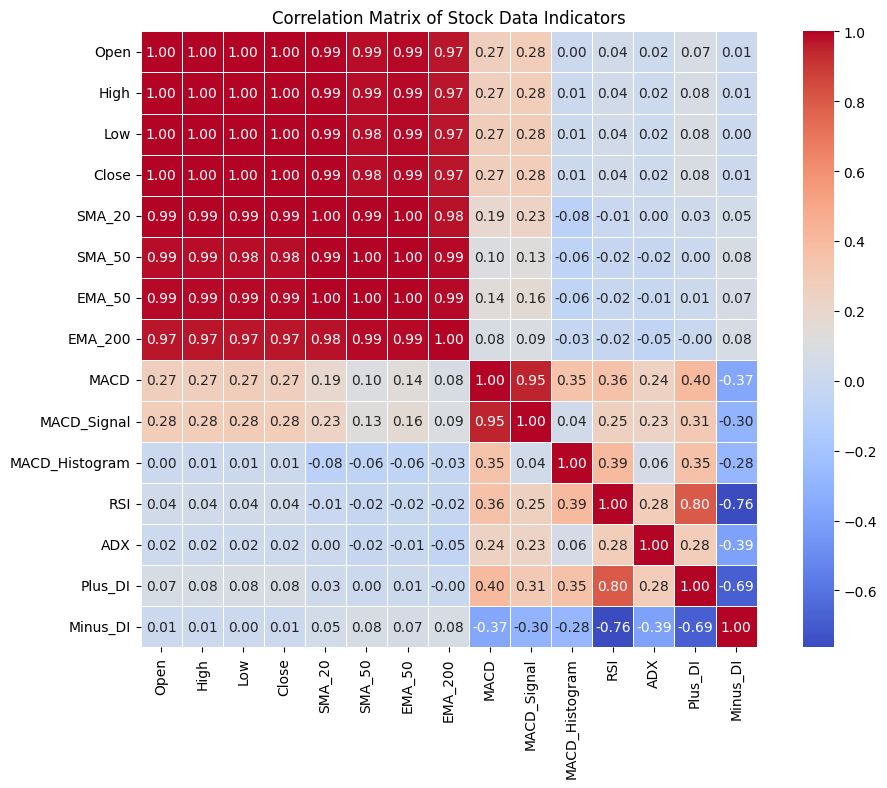

In [58]:
# Visualising the correlation matrix for the stock data
correlation_matrix = stock_data.corr()

# Set up thefigure size
plt.figure(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
            linewidths=.5, annot_kws={"size": 10})
plt.title('Correlation Matrix of Stock Data Indicators')
plt.show()


**STOCK DATA PREPROCESSING**


In [59]:
# Preprocessing function for stock data
def preprocess_stock_data(data, start_date, end_date):
    """
    Preprocess stock data for the given date range and prepare it for training.

    Parameters:
        data (pd.DataFrame): The stock data with 'Date' as an index and columns ['Open', 'High', 'Low', 'Close', 'Volume', ...].
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.

    Returns:
        X_train, X_test, y_train, y_test: Training and testing datasets.
        scaler_y: Scaler for the target variable.
    """

    # Filter data within the specified date range
    filtered_data = data.loc[start_date:end_date]

    # Handle missing values (drop rows with NaNs)
    filtered_data = filtered_data.dropna()

    # Define the features and target variable
    feature_columns = [col for col in filtered_data.columns if col not in ['Date', 'Close']]
    target_column = 'Close'

    # Select features and target
    features = filtered_data[feature_columns]
    target = filtered_data[target_column]

    # Normalize features using MinMaxScaler
    scaler_X = MinMaxScaler()
    features_scaled = scaler_X.fit_transform(features)

    # Normalize target using MinMaxScaler
    # Initialize MinMaxScaler for the target variable (y)
    scaler_y = MinMaxScaler()
    target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

    # Split into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, shuffle=False)



    return X_train, X_test, y_train, y_test, scaler_X, scaler_y
X_train, X_test, y_train, y_test, scaler_X, scaler_y = preprocess_stock_data(stock_data, start_date='2021-09-30', end_date='2022-09-30')
# Displaying the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

filtered_data.head()


X_train shape: (201, 14)
X_test shape: (51, 14)
y_train shape: (201, 1)
y_test shape: (51, 1)


,Open,High,Low,Close,SMA_20,SMA_50,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
Date,,,,,,,,,,,,,,,
2018-10-01 00:00:00-04:00,20.384666,20.762667,20.070000,20.713333,19.411700,20.723933,20.391357,20.886165,-0.206465,-0.331736,0.125271,60.786743,16.544206,29.889921,32.572710
2018-10-02 00:00:00-04:00,20.930000,21.122667,19.943333,20.068001,19.451933,20.721027,20.378676,20.878024,-0.168661,-0.299121,0.130460,53.652080,15.486103,29.504991,30.544296
2018-10-03 00:00:00-04:00,20.222000,20.306667,19.438000,19.653334,19.498800,20.717520,20.350231,20.865838,-0.170199,-0.273337,0.103138,51.796532,14.868813,27.046929,31.021133
2018-10-04 00:00:00-04:00,19.596666,19.600000,18.511333,18.788668,19.501733,20.681640,20.288993,20.845169,-0.238441,-0.266358,0.027917,45.710623,14.915649,24.497848,33.502057
2018-10-05 00:00:00-04:00,18.309999,18.325333,17.333332,17.463333,19.497433,20.622040,20.178183,20.811519,-0.394915,-0.292069,-0.102845,40.622684,15.641794,21.971450,36.682955


****MODEL SELECTION AND TRAINING ON THE STOCK DATA****

**Model 1**: Linear Regression (Traditional Machine Learning Model)
Linear Regression is a simple, interpretable model, useful for modeling trends in stock data.

Train Root Mean Squared Error (RMSE): 4.01
Test  Root Mean Squared Error (RMSE): 4.58
Train R² Score: 0.99
Test  R² Score: 0.90


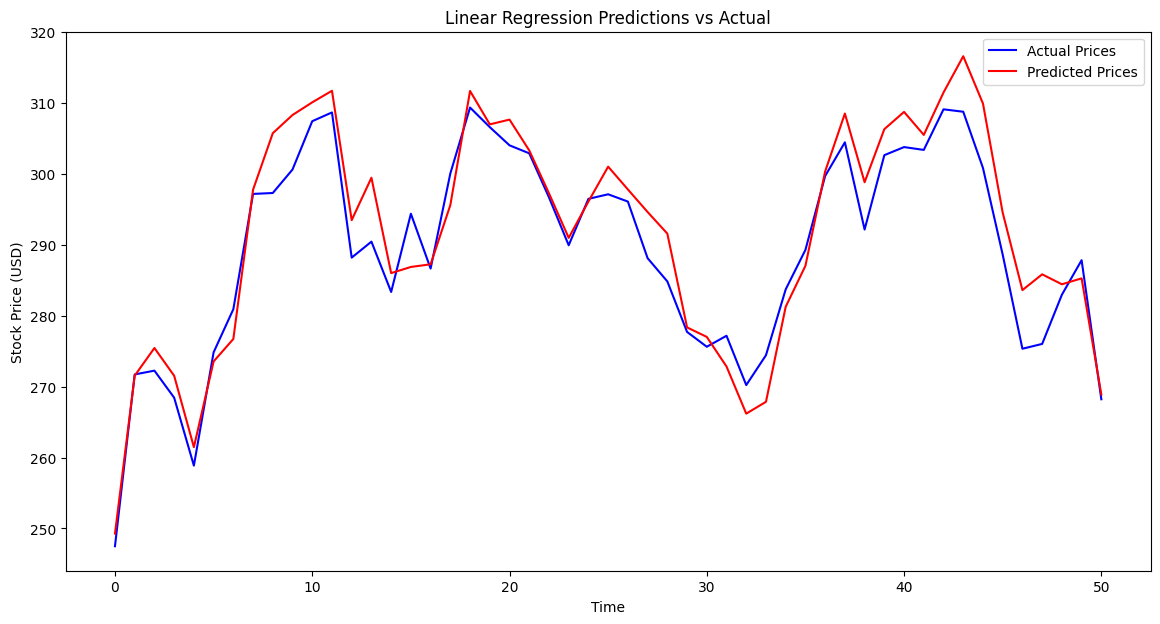

In [17]:
# Train a Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the train and test sets
linear_train_pred = linear_model.predict(X_train)
linear_test_pred = linear_model.predict(X_test)

# Convert y_train and y_test to NumPy arrays before reshaping
linear_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))  # Reshaping to 2D for inverse_transform
linear_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))    # Reshaping to 2D for inverse_transform
linear_train_pred_actual = scaler_y.inverse_transform(linear_train_pred.reshape(-1, 1))
linear_test_pred_actual = scaler_y.inverse_transform(linear_test_pred.reshape(-1, 1))

# Evaluate the model using RMSE
linear_train_rmse = np.sqrt(mean_squared_error(linear_train_actual, linear_train_pred_actual))
linear_test_rmse = np.sqrt(mean_squared_error(linear_test_actual, linear_test_pred_actual))

# Evaluate the model using R² score
linear_train_r2 = r2_score(linear_train_actual, linear_train_pred_actual)
linear_test_r2 = r2_score(linear_test_actual, linear_test_pred_actual)

print(f"Train Root Mean Squared Error (RMSE): {linear_train_rmse:.2f}")
print(f"Test  Root Mean Squared Error (RMSE): {linear_test_rmse:.2f}")
print(f"Train R² Score: {linear_train_r2 :.2f}")
print(f"Test  R² Score: {linear_test_r2:.2f}")

# Visualizing predictions vs actual values for the test set
plt.figure(figsize=(14, 7))
plt.plot(linear_test_actual, label='Actual Prices', color='blue')
plt.plot(linear_test_pred_actual, label='Predicted Prices', color='red')
plt.title('Linear Regression Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


In [18]:
# Build and train XGB model
def build_and_train_xgb_model(X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb):
    """
    Build and train an XGBoost model and evaluate its performance.

    Parameters:
    X_train_xgb (np.ndarray): Training data for features.
    y_train_xgb (np.ndarray): Training data for the target variable.
    X_test_xgb (np.ndarray): Test data for features.
    y_test_xgb (np.ndarray): Test data for the target variable.

    Returns:
    xgb_model (XGBRegressor): Trained XGBoost model.
    """
    # Initialize the XGBoost model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

    # Train the model
    xgb_model.fit(
        X_train_xgb,
        y_train_xgb.ravel(),
        eval_set=[(X_test_xgb, y_test_xgb)],
        verbose=True
    )

    return xgb_model

[0]	validation_0-rmse:0.08688
[1]	validation_0-rmse:0.07855
[2]	validation_0-rmse:0.07119
[3]	validation_0-rmse:0.06617
[4]	validation_0-rmse:0.06070
[5]	validation_0-rmse:0.05575
[6]	validation_0-rmse:0.05210
[7]	validation_0-rmse:0.04914
[8]	validation_0-rmse:0.04613
[9]	validation_0-rmse:0.04276
[10]	validation_0-rmse:0.04024
[11]	validation_0-rmse:0.03781
[12]	validation_0-rmse:0.03570
[13]	validation_0-rmse:0.03392
[14]	validation_0-rmse:0.03235
[15]	validation_0-rmse:0.03090
[16]	validation_0-rmse:0.02938
[17]	validation_0-rmse:0.02854
[18]	validation_0-rmse:0.02765
[19]	validation_0-rmse:0.02726
[20]	validation_0-rmse:0.02713
[21]	validation_0-rmse:0.02667
[22]	validation_0-rmse:0.02666
[23]	validation_0-rmse:0.02636
[24]	validation_0-rmse:0.02629
[25]	validation_0-rmse:0.02611
[26]	validation_0-rmse:0.02606
[27]	validation_0-rmse:0.02594
[28]	validation_0-rmse:0.02585
[29]	validation_0-rmse:0.02578
[30]	validation_0-rmse:0.02580
[31]	validation_0-rmse:0.02566
[32]	validation_0-

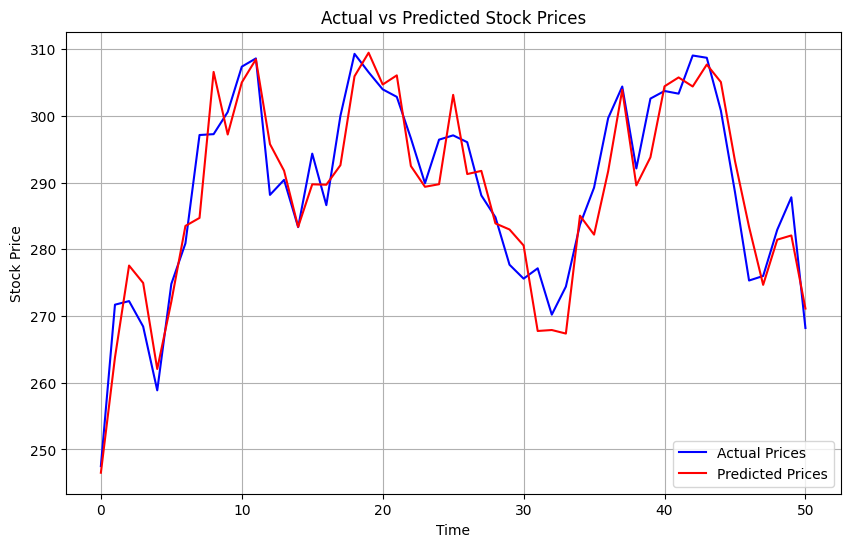

In [19]:
from sklearn.metrics import r2_score

# Make predictions and evaluate performance
def predict_and_evaluate_xgb(xgb_model, X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb, scaler_y):
    """
    Make predictions using the trained XGBoost model and evaluate the performance.

    Parameters:
    xgb_model (XGBRegressor): Trained XGBoost model.
    X_train (np.ndarray): Training data for features.
    y_train (np.ndarray): Training data for target variable.
    X_test (np.ndarray): Test data for features.
    y_test (np.ndarray): Test data for target variable.
    scaler_y (MinMaxScaler): Scaler used for the target variable.

    Returns:
    dict: A dictionary containing evaluation metrics (RMSE, R²) for both train and test sets, and actual vs predicted values.
    """
    # Predict on the train and test sets
    xgb_train_pred_scaled = xgb_model.predict(X_train)
    xgb_test_pred_scaled = xgb_model.predict(X_test)

    # Inverse transform the predictions and target to original scale
    xgb_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    xgb_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    xgb_train_pred_actual = scaler_y.inverse_transform(xgb_train_pred_scaled.reshape(-1, 1))
    xgb_test_pred_actual = scaler_y.inverse_transform(xgb_test_pred_scaled.reshape(-1, 1))

    # Calculate RMSE and R² for train and test sets
    xgb_train_rmse = np.sqrt(mean_squared_error(xgb_train_actual, xgb_train_pred_actual))
    xgb_test_rmse = np.sqrt(mean_squared_error(xgb_test_actual, xgb_test_pred_actual))
    xgb_train_r2 = r2_score(xgb_train_actual, xgb_train_pred_actual)
    xgb_test_r2 = r2_score(xgb_test_actual, xgb_test_pred_actual)

    print(f"Train Root Mean Squared Error (RMSE): {xgb_train_rmse:.2f}")
    print(f"Test  Root Mean Squared Error (RMSE): {xgb_test_rmse:.2f}")
    print(f"Train R² Score: {xgb_train_r2:.2f}")
    print(f"Test  R² Score: {xgb_test_r2:.2f}")

    return {
        'Train_RMSE': xgb_train_rmse,
        'Test_RMSE': xgb_test_rmse,
        'Train_R2': xgb_train_r2,
        'Test_R2': xgb_test_r2,
        'y_test_actual': xgb_test_actual,
        'y_test_pred_actual': xgb_test_pred_actual
    }

# Train the XGBoost model
xgb_model = build_and_train_xgb_model(X_train, y_train, X_test, y_test)

# Predict and evaluate
xgb_results = predict_and_evaluate_xgb(xgb_model, X_train, y_train, X_test, y_test, scaler_y)

# Extract metrics and actual/predicted values
xgb_test_actual = xgb_results['y_test_actual']
xgb_test_pred_actual = xgb_results['y_test_pred_actual']

# Display actual vs predicted
comparison_df = pd.DataFrame({'Actual': xgb_test_actual.ravel(), 'Predicted': xgb_test_pred_actual.ravel()})
print("\nActual vs Predicted:")
print(comparison_df.head())

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(xgb_test_actual, label='Actual Prices', color='blue')
plt.plot(xgb_test_pred_actual, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()



In [20]:
# Preprocessing function of the stock data for the LSTM model
def preprocess_stock_data_lstm(data, feature_columns, target_column, look_back=60):
    """
    Prepare data for LSTM model by creating sequences.

    Parameters:
        data (pd.DataFrame): Stock data with features and target column.
        feature_columns (list): Columns used as features.
        target_column (str): Column to be predicted.
        look_back (int): Number of past time steps to use as input.

    Returns:
        X, y: Features and target arrays for training/testing.
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[feature_columns + [target_column]])

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i - look_back:i, :-1])  # Features (all except target)
        y.append(scaled_data[i, -1])  # Target (last column)
    return np.array(X), np.array(y), scaler


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0015 - val_loss: 0.0349
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6112e-04 - val_loss: 0.0294
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.3821e-05 - val_loss: 0.0315
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5557e-05 - val_loss: 0.0213
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.9500e-05 - val_loss: 0.0202
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0017e-05 - val_loss: 0.0076
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5804e-05 - val_loss: 0.0076
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.5421e-05 - val_loss: 0.0048
Epoch 9/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.5563e-05 - val_loss: 0.0035
Epoch 10/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0364e-05 - val_loss: 0.0054
Epoch 11/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2262e-05 - val_loss: 0.0036
Epoch 12/50

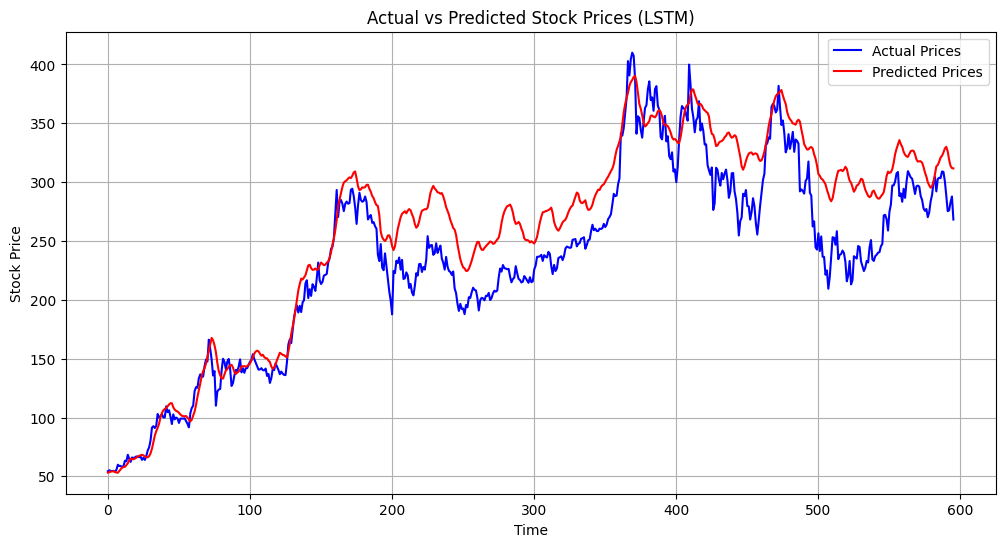

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define LSTM model
def build_lstm_model(input_shape):
    """
    Build and compile an LSTM model.

    Parameters:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prepare data
look_back = 60
feature_columns = [col for col in filtered_data.columns if col not in ['Date', 'Close']]
target_column = 'Close'
X, y, scaler = preprocess_stock_data_lstm(stock_data, feature_columns, target_column, look_back=look_back)

# Split into train/test sets (80/20)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build and train LSTM model
lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
history = lstm_model.fit(
    X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1
)

# Predictions
lstm_train_pred_scaled = lstm_model.predict(X_train)
lstm_test_pred_scaled = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
lstm_train_actual = scaler.inverse_transform(
    np.hstack((np.zeros((y_train.shape[0], len(feature_columns))), y_train.reshape(-1, 1)))
)[:, -1]
lstm_test_actual = scaler.inverse_transform(
    np.hstack((np.zeros((y_test.shape[0], len(feature_columns))), y_test.reshape(-1, 1)))
)[:, -1]
lstm_train_pred_actual = scaler.inverse_transform(
    np.hstack((np.zeros((lstm_train_pred_scaled.shape[0], len(feature_columns))), lstm_train_pred_scaled))
)[:, -1]
lstm_test_pred_actual = scaler.inverse_transform(
    np.hstack((np.zeros((lstm_test_pred_scaled.shape[0], len(feature_columns))), lstm_test_pred_scaled))
)[:, -1]

# Evaluation metrics
lstm_train_rmse = np.sqrt(mean_squared_error(lstm_train_actual, lstm_train_pred_actual))
lstm_test_rmse = np.sqrt(mean_squared_error(lstm_test_actual, lstm_test_pred_actual))
lstm_train_r2 = r2_score(lstm_train_actual, lstm_train_pred_actual)
lstm_test_r2 = r2_score(lstm_test_actual, lstm_test_pred_actual)

print(f"Train Root Mean Squared Error (RMSE): {lstm_train_rmse:.2f}")
print(f"Test  Root Mean Squared Error (RMSE): {lstm_test_rmse:.2f}")
print(f"Train R² Score: {lstm_train_r2:.2f}")
print(f"Test  R² Score: {lstm_test_r2:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(lstm_test_actual, label='Actual Prices', color='blue')
plt.plot(lstm_test_pred_actual, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices (LSTM)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


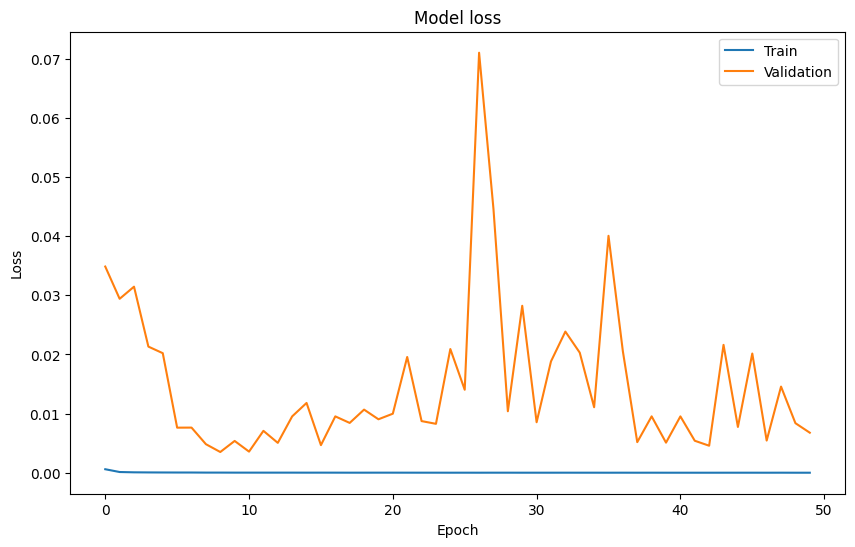

In [22]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**Hyperparameter Tuning For The LSTM model**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Root Mean Squared Error (RMSE): 1.89
Test Root Mean Squared Error (RMSE): 2.25
Train R² Score: 0.92
Test R² Score: 0.96


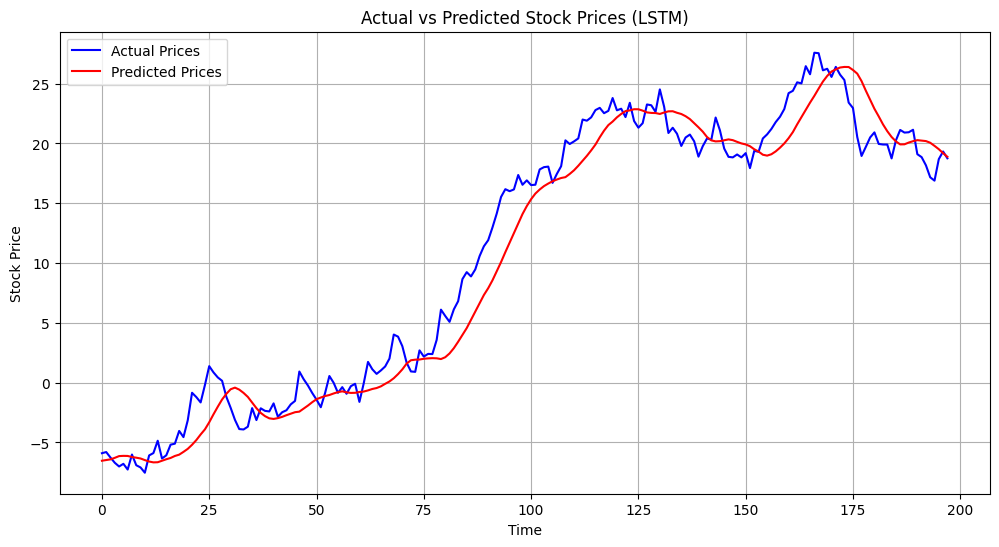

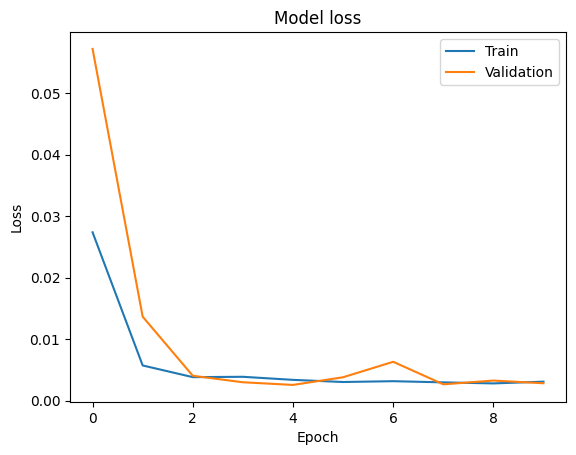

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Adding Sample Data (Replace with your actual data)
np.random.seed(42)
time_steps = 1000
data = np.cumsum(np.random.normal(0, 1, time_steps))
df = pd.DataFrame({'value': data})

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:] # Renamed X_val to X_test and y_val to y_test

# Improved LSTM Model
model = keras.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(32))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

# Training with Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0) # use test data as validation during training

# Evaluation
y_train_pred_scaled = model.predict(X_train)
y_test_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values
y_train_pred = scaler.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler.inverse_transform(y_test_pred_scaled)
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

lstm_train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
lstm_test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))

lstm_train_r2 = r2_score(y_train_true, y_train_pred)
lstm_test_r2 = r2_score(y_test_true, y_test_pred)

print(f"Train Root Mean Squared Error (RMSE): {lstm_train_rmse:.2f}")
print(f"Test Root Mean Squared Error (RMSE): {lstm_test_rmse:.2f}")
print(f"Train R² Score: {lstm_train_r2:.2f}")
print(f"Test R² Score: {lstm_test_r2:.2f}")


# Plotting Actual vs. Predicted (Test Set)
plt.figure(figsize=(12, 6))
plt.plot(y_test_true, label='Actual Prices', color='blue')
plt.plot(y_test_pred, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices (LSTM)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


# Plotting the loss and validation function
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation') #Plot validation loss
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

###**Hyperparameter Tuning, Feature Engineering, and Evaluation**

###**SENTIMENT DATA**

In [24]:
# Import and mount Google Drive.
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [25]:
file_path = "/content/drive/MyDrive/stock_tweets.csv"
stock_tweets = pd.read_csv(file_path)
stock_tweets.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [26]:
# Checking the data structure and summary of the sentiment data
print("Data Info:")
stock_tweets.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [27]:
# Display the basic statistical details of the sentiment data
print("\nData Description:")
stock_tweets.describe(include='all')


Data Description:


,Date,Tweet,Stock Name,Company Name
count,80793,80793,80793,80793
unique,64424,64479,25,25
top,2022-07-07 18:32:41+00:00,$TSLA will triple in 2022 🚀🌕,TSLA,"Tesla, Inc."
freq,14,25,37422,37422


In [28]:
#Checking for missing values
print("\nMissing Values:")
stock_tweets.isnull().sum()



Missing Values:


,0
Date,0
Tweet,0
Stock Name,0
Company Name,0


In [29]:
# Checking for duplicates tweets
duplicate_count = stock_tweets.duplicated().sum()
print(f"\nNumber of Duplicate Entries: {duplicate_count}")


Number of Duplicate Entries: 0


In [30]:
# Count stock mentions
stock_counts = stock_tweets['Stock Name'].value_counts()
print("\nMost Mentioned Stocks:")
stock_counts.head()


Most Mentioned Stocks:


,count
Stock Name,
TSLA,37422
TSM,11034
AAPL,5056
PG,4089
AMZN,4089


In [31]:
#Convert 'Date' to datetime and extract Year, Month, Day, Hour
stock_tweets['Date'] = pd.to_datetime(stock_tweets['Date'], errors='coerce')


<ipython-input-32-fe002e256a76>:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  stock_tweets['Month_Year'] = stock_tweets['Date'].dt.to_period('M')
<ipython-input-32-fe002e256a76>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stock_counts.index[:10], y=stock_counts.values[:10], palette='viridis')


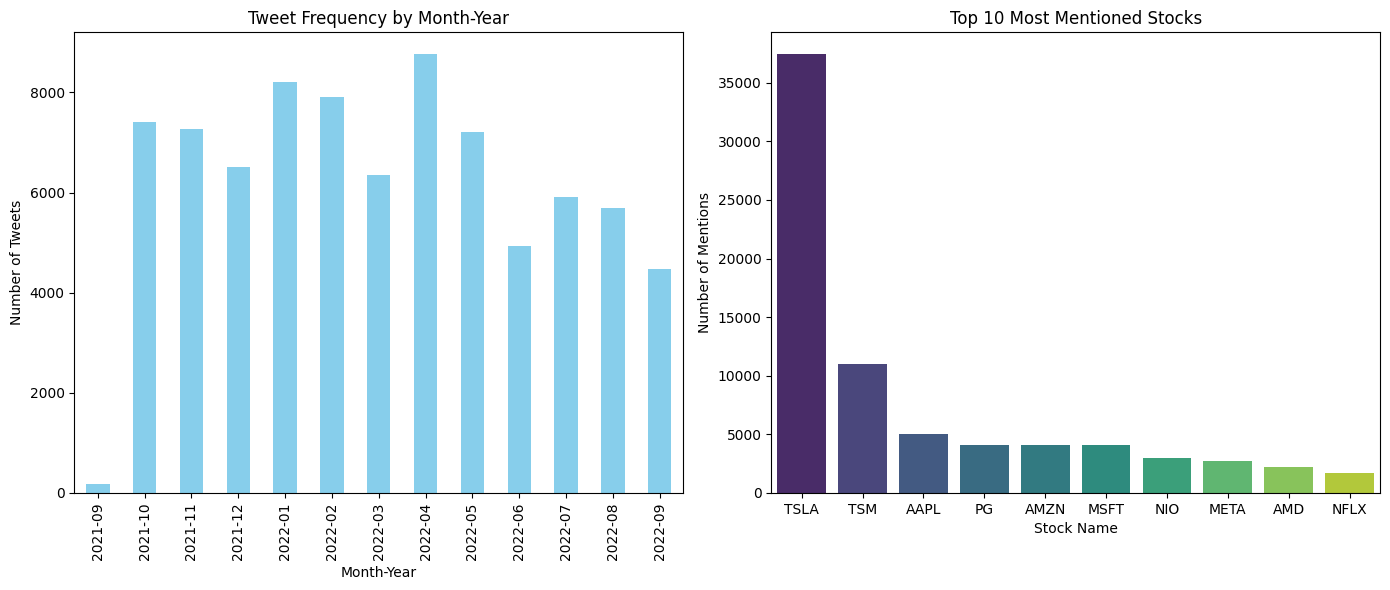

In [32]:
# Visualising tweet frequncy and top most mentioned tweet of the sentiment data
plt.figure(figsize=(14, 6))

# Tweet Frequency by Year and Month
plt.subplot(1, 2, 1)
stock_tweets['Month_Year'] = stock_tweets['Date'].dt.to_period('M')
stock_tweets['Month_Year'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Tweet Frequency by Month-Year")
plt.xlabel("Month-Year")
plt.ylabel("Number of Tweets")

# Stock Mentions
plt.subplot(1, 2, 2)
sns.barplot(x=stock_counts.index[:10], y=stock_counts.values[:10], palette='viridis')
plt.title("Top 10 Most Mentioned Stocks")
plt.xlabel("Stock Name")
plt.ylabel("Number of Mentions")

plt.tight_layout()
plt.show()

In [33]:
# We working with the TSLA tweet for this project
# Filtering the rows where the stock name is "TSLA" and create a dataframe
if 'Stock Name' in stock_tweets.columns:
    tsla_df = stock_tweets[stock_tweets['Stock Name'] == 'TSLA']
    print("\nFiltered Dataset (TSLA):")
else:
    print("\nError: Column 'Stock' does not exist in the dataset.")
tsla_df.head()



Filtered Dataset (TSLA):


,Date,Tweet,Stock Name,Company Name,Month_Year
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",2022-09
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",2022-09
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",2022-09
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",2022-09
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",2022-09


****SENTIMENT (TSLA TWEET) DATA EXPLORATORY DATA ANALYSIS****

<ipython-input-34-0b95bc8f53e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Tweet_Length'] = tsla_df['Tweet'].apply(len)


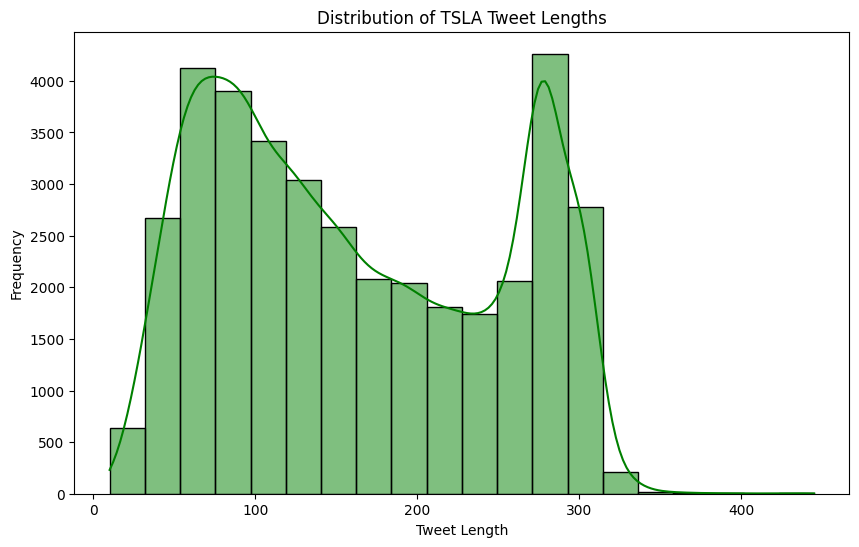

In [34]:
# Visualising the distribution of the TSLA tweet lenghts

tsla_df['Tweet_Length'] = tsla_df['Tweet'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(tsla_df['Tweet_Length'], kde=True, color='green', bins=20)
plt.title("Distribution of TSLA Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()


<ipython-input-35-52a926e02272>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Hour'] = tsla_df['Date'].dt.hour
<ipython-input-35-52a926e02272>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tweet_counts_by_hour.index, y=tweet_counts_by_hour.values, palette='Blues')


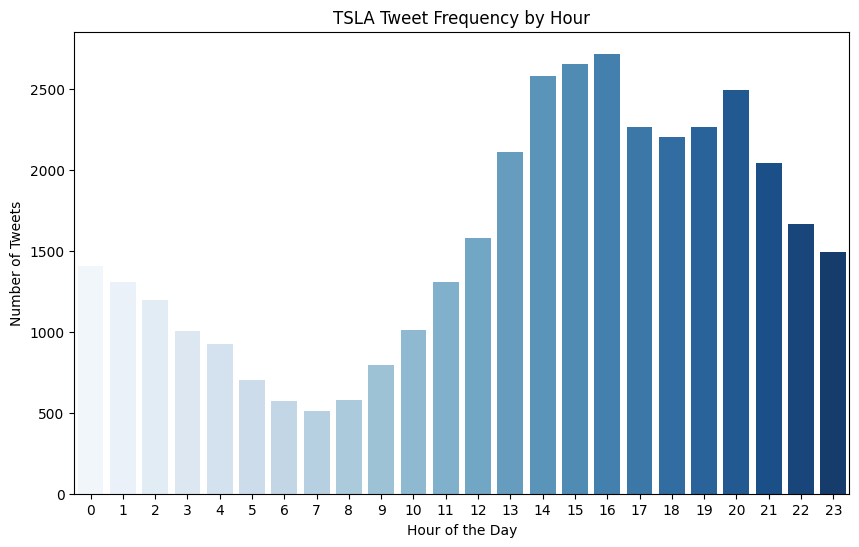

In [35]:
# Visualising the TSLA tweet frequency by hour
tsla_df['Hour'] = tsla_df['Date'].dt.hour
tweet_counts_by_hour = tsla_df['Hour'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=tweet_counts_by_hour.index, y=tweet_counts_by_hour.values, palette='Blues')
plt.title("TSLA Tweet Frequency by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Tweets")
plt.show()


<ipython-input-36-01be463105d6>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  tsla_df['Month_Year'] = tsla_df['Date'].dt.to_period('M')
<ipython-input-36-01be463105d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Month_Year'] = tsla_df['Date'].dt.to_period('M')


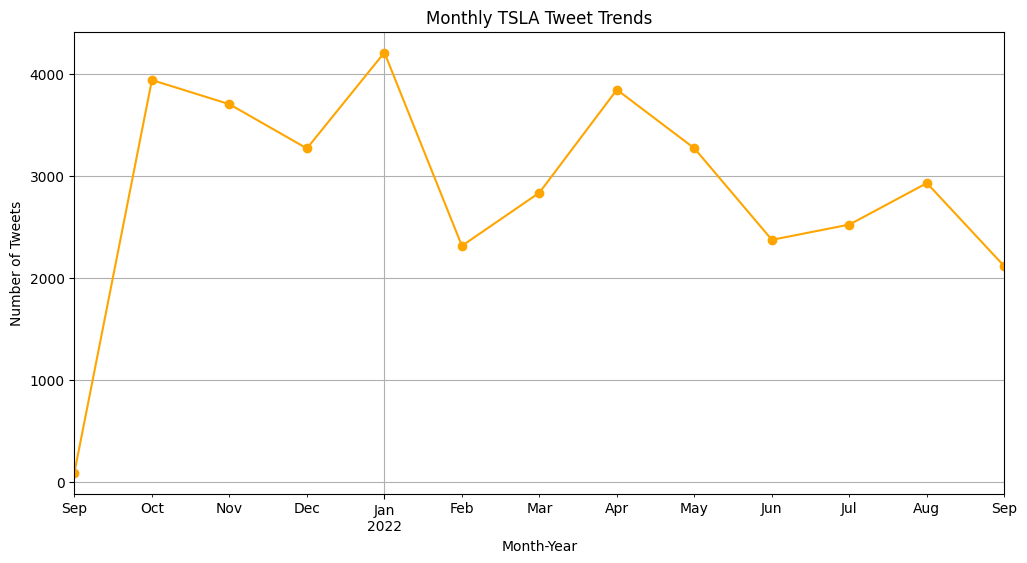

In [36]:
# Visualising the TSLA tweet frequency by months of the year
tsla_df['Month_Year'] = tsla_df['Date'].dt.to_period('M')
monthly_tweet_counts = tsla_df['Month_Year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_tweet_counts.plot(kind='line', marker='o', color='orange')
plt.title("Monthly TSLA Tweet Trends")
plt.xlabel("Month-Year")
plt.ylabel("Number of Tweets")
plt.grid()
plt.show()


****PREPROCESSING THE TSLA TWEET DATA****

In [37]:
# Downloading the NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean the tweet text
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\S+', '', tweet)  # Remove mentions
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)  # Remove non-alphabetic characters
    tweet = tweet.lower()  # Convert to lowercase
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])  # Remove stop words
    return tweet

# Clean the tweet column
tsla_df['Cleaned_Tweet'] = tsla_df['Tweet'].apply(clean_tweet)

# Check cleaned data
tsla_df[['Tweet', 'Cleaned_Tweet']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-37-5b0372eda7db>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Cleaned_Tweet'] = tsla_df['Tweet'].apply(clean_tweet)


,Tweet,Cleaned_Tweet
0,Mainstream media has done an amazing job at br...,mainstream media done amazing job brainwashing...
1,Tesla delivery estimates are at around 364k fr...,tesla delivery estimates around k analysts tsla
2,3/ Even if I include 63.0M unvested RSUs as of...,even include unvested rsus additional equity n...
3,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,hahaha still trying stop tesla fsd bro get shi...
4,"@RealDanODowd @Tesla Stop trying to kill kids,...",stop trying kill kids sad deranged old man


In [43]:
from transformers import pipeline as transformers_pipeline  # Import with alias

sentiment_analyzer = transformers_pipeline('sentiment-analysis')


# Load pre-trained sentiment analysis pipeline from HuggingFace
sentiment_analyzer = transformers_pipeline('sentiment-analysis')

# Function to predict sentiment for each tweet
def get_sentiment_score(tweet):
    result = sentiment_analyzer(tweet)
    return result[0]['label'], result[0]['score']

# Apply sentiment analysis to the cleaned tweets
tsla_df[['Sentiment', 'Sentiment_Score']] = tsla_df['Cleaned_Tweet'].apply(lambda x: pd.Series(get_sentiment_score(x)))

# Check the results
tsla_df[['Cleaned_Tweet', 'Sentiment', 'Sentiment_Score']].head()


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0
<ipython-input-43-b6c7198ab426>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df[['Sentiment', 'Sentime

,Cleaned_Tweet,Sentiment,Sentiment_Score
0,mainstream media done amazing job brainwashing...,NEGATIVE,0.981137
1,tesla delivery estimates around k analysts tsla,NEGATIVE,0.954435
2,even include unvested rsus additional equity n...,NEGATIVE,0.997324
3,hahaha still trying stop tesla fsd bro get shi...,NEGATIVE,0.999142
4,stop trying kill kids sad deranged old man,NEGATIVE,0.994961


In [60]:
# Feature engineering: tweet length, number of hashtags, mentions, and sentiment scores
tsla_df['Tweet_Length'] = tsla_df['Cleaned_Tweet'].apply(len)
tsla_df['Num_Hashtags'] = tsla_df['Tweet'].apply(lambda x: len(re.findall(r'#\w+', x)))
tsla_df['Num_Mentions'] = tsla_df['Tweet'].apply(lambda x: len(re.findall(r'@\w+', x)))

# Group by date and aggregate sentiment scores for daily features
# Convert 'Date' column back to datetime before using .dt.date
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'].astype(str)) # Converting 'period[M]' to datetime
tsla_df['Date'] = tsla_df['Date'].dt.date  # Convert to date only
daily_sentiment = tsla_df.groupby('Date').agg(
    avg_sentiment_score=('Sentiment_Score', 'mean'),
    total_tweets=('Sentiment', 'count'),
    avg_tweet_length=('Tweet_Length', 'mean'),
    avg_num_hashtags=('Num_Hashtags', 'mean'),
    avg_num_mentions=('Num_Mentions', 'mean')
).reset_index()

# Check aggregated data
daily_sentiment.head()


<ipython-input-60-89ab6d74e545>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Tweet_Length'] = tsla_df['Cleaned_Tweet'].apply(len)
<ipython-input-60-89ab6d74e545>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Num_Hashtags'] = tsla_df['Tweet'].apply(lambda x: len(re.findall(r'#\w+', x)))
<ipython-input-60-89ab6d74e545>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,Date,avg_sentiment_score,total_tweets,avg_tweet_length,avg_num_hashtags,avg_num_mentions
0,2021-09-30,0.933956,90,99.200000,0.277778,0.655556
1,2021-10-01,0.946215,94,98.978723,0.191489,0.734043
2,2021-10-02,0.936372,116,88.103448,0.232759,0.620690
3,2021-10-03,0.935579,61,108.868852,0.213115,0.639344
4,2021-10-04,0.934877,119,83.319328,0.134454,0.445378


****FEATURE ENGINEERING****

In [97]:
# Ensure 'Date' is a column, not an index
if 'Date' not in original_stock_data.columns:
    original_stock_data = original_stock_data.reset_index()  # Reset index to move 'Date' back to a column

if 'Date' not in daily_sentiment.columns:
    daily_sentiment = daily_sentiment.reset_index()

# Convert 'Date' columns in both DataFrames to the same format
original_stock_data['Date'] = pd.to_datetime(original_stock_data['Date']).dt.date  # Convert to datetime.date
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date']).dt.date  # Convert to datetime.date

# Merge stock data with daily sentiment data
data = pd.merge(original_stock_data, daily_sentiment, on='Date', how='inner') # Changed original_stock_data to stock_data

# Check the merged data
data.head()


,Date,Open,High,Low,Close,SMA_20,SMA_50,EMA_50,EMA_200,MACD,...,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI,avg_sentiment_score,total_tweets,avg_tweet_length,avg_num_hashtags,avg_num_mentions
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,251.648502,239.699468,241.751282,216.204206,5.700370,...,0.420555,64.298745,14.286528,25.602899,17.336323,0.933956,90,99.200000,0.277778,0.655556
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,252.362336,240.539202,242.404434,216.624131,5.558636,...,0.223057,62.331602,13.902687,25.350030,21.201050,0.946215,94,98.978723,0.191489,0.734043
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,253.161670,241.460202,243.114457,217.060807,5.552032,...,0.173163,63.671942,14.694541,31.289169,18.778048,0.934877,119,83.319328,0.134454,0.445378
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,253.622836,242.280002,243.784347,217.490019,5.458591,...,0.063777,59.899231,15.307149,28.609253,17.807568,0.951680,88,104.340909,0.204545,0.659091
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,254.104169,243.199802,244.456202,217.922125,5.380611,...,-0.011362,60.217334,15.809982,26.378192,16.742171,0.953122,78,85.474359,0.448718,0.474359


In [98]:
# Dropping the unnecessary columns for preprocessing
# Check if the columns exist before dropping
columns_to_drop = ['Dividends', 'Stock Splits']
columns_to_drop = [col for col in columns_to_drop if col in data.columns]

stock_tweet_data = data.drop(columns=columns_to_drop)
stock_tweet_data.head()

,Date,Open,High,Low,Close,SMA_20,SMA_50,EMA_50,EMA_200,MACD,...,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI,avg_sentiment_score,total_tweets,avg_tweet_length,avg_num_hashtags,avg_num_mentions
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,251.648502,239.699468,241.751282,216.204206,5.700370,...,0.420555,64.298745,14.286528,25.602899,17.336323,0.933956,90,99.200000,0.277778,0.655556
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,252.362336,240.539202,242.404434,216.624131,5.558636,...,0.223057,62.331602,13.902687,25.350030,21.201050,0.946215,94,98.978723,0.191489,0.734043
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,253.161670,241.460202,243.114457,217.060807,5.552032,...,0.173163,63.671942,14.694541,31.289169,18.778048,0.934877,119,83.319328,0.134454,0.445378
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,253.622836,242.280002,243.784347,217.490019,5.458591,...,0.063777,59.899231,15.307149,28.609253,17.807568,0.951680,88,104.340909,0.204545,0.659091
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,254.104169,243.199802,244.456202,217.922125,5.380611,...,-0.011362,60.217334,15.809982,26.378192,16.742171,0.953122,78,85.474359,0.448718,0.474359


In [95]:
stock_tweet_data.describe()

,Open,High,Low,Close,SMA_20,SMA_50,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI,avg_sentiment_score,total_tweets,avg_tweet_length,avg_num_hashtags,avg_num_mentions
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,300.295542,307.656601,292.253823,299.864947,298.490638,295.447575,295.648828,274.320579,1.274973,1.336358,-0.061384,52.759431,23.227792,26.823695,24.396274,0.952179,119.158730,94.150179,0.261508,0.622200
std,46.161120,46.804121,44.718813,45.812123,41.103250,35.085854,30.842219,20.867372,12.654949,11.745764,4.234958,17.911393,10.051226,9.147891,7.474003,0.010649,51.443608,7.645160,0.100036,0.212580
min,207.949997,217.973328,206.856674,209.386673,231.434334,237.535334,241.751282,216.204206,-25.271333,-22.213158,-7.678481,15.436319,9.382026,9.095958,1.954825,0.921067,46.000000,72.496350,0.065217,0.175182
25%,266.860825,273.241661,260.780823,267.203331,265.233167,263.703535,269.207022,273.137595,-9.307914,-9.294600,-3.443494,40.606929,16.465301,20.440324,20.271608,0.944997,87.000000,88.635706,0.192211,0.481928
50%,298.750000,304.158325,289.565002,296.856659,292.829167,300.646933,298.850483,279.662658,1.506031,2.278616,0.223006,49.667595,20.898588,25.585256,25.056400,0.952351,103.000000,94.407450,0.250000,0.590082
75%,335.700005,344.957512,327.908340,336.472504,338.758374,319.797798,322.985639,286.566026,9.424874,9.324321,2.517216,62.951301,26.342963,31.204020,29.368782,0.959339,135.500000,99.596330,0.309643,0.723676
max,411.470001,414.496674,405.666656,409.970001,373.152498,357.870532,344.030730,298.242573,38.067930,31.285426,10.296174,97.129203,63.325957,66.743503,44.249155,0.975639,462.000000,109.414634,0.683673,1.416667


In [68]:
stock_tweet_data.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
SMA_20,0
SMA_50,0
EMA_50,0
EMA_200,0
MACD,0


In [69]:
stock_tweet_data.shape

(252, 21)

In [99]:
# Preprocessing function for stock tweet data
def preprocess_stock_tweet_data(cleared_data, start_date, end_date):
    """
    Preprocess merged stock data and tweet data for the given date range and prepare it for training.

    Parameters:
        data (pd.DataFrame): The stock data with 'Date' as an index and columns ['Open', 'High', 'Low', 'Close', 'Volume', ...].
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.

    Returns:
        X_train, X_test, y_train, y_test: Training and testing datasets.
        scaler_y: Scaler for the target variable.
        cleared_data: The preprocessed DataFrame. # Added this to return cleared_data
    """

    # Filter data within the specified date range
    # Use the correct data format for the start_date and end_date if necessary.
    # For example:
    # data['Date'] = pd.to_datetime(data['Date'])
    # cleared_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Alternatively, if 'Date' is in datetime format and already the index:
    # Ensure 'Date' is the index and in datetime format

    # 'Date' is likely already a column, convert if needed:
    if cleared_data['Date'].dtype != 'datetime64[ns]':
        cleared_data['Date'] = pd.to_datetime(cleared_data['Date'])

    cleared_data.set_index('Date', inplace=True) # Set 'Date' as index
    cleared_data = cleared_data.loc[start_date:end_date]

    # Handle missing values (drop rows with NaNs)
    cleared_data = cleared_data.dropna()

    # Check if enough data for splitting. If not, adjust or skip the split.
    if len(cleared_data) < 2:
      print("Insufficient data for train-test split.")
      return None, None, None, None, None, None # Or handle appropriately.

    # Define the features and target variable
    feature_columns = [col for col in cleared_data.columns if col not in ['Close']] # Removed 'Date' as it's the index now
    target_column = 'Close'

    # Select features and target
    features = cleared_data[feature_columns]
    target = cleared_data[target_column]

    # Normalize features using MinMaxScaler
    scaler_X = MinMaxScaler()
    features_scaled = scaler_X.fit_transform(features)

    # Normalize target using MinMaxScaler
    # Initialize MinMaxScaler for the target variable (y)
    scaler_y = MinMaxScaler()
    target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

    # Split into training and testing sets (80% train, 20% test)
    X_train_tweet, X_test_tweet, y_train_tweet, y_test_tweet = train_test_split(features_scaled, target_scaled, test_size=0.2, shuffle=False)



    return X_train_tweet, X_test_tweet, y_train_tweet, y_test_tweet, scaler_X, scaler_y, cleared_data


# Now call the function and assign the returned values including cleared_data
X_train_tweet, X_test_tweet, y_train_tweet, y_test_tweet, scaler_X, scaler_y, cleared_data = preprocess_stock_tweet_data(stock_tweet_data.copy(), start_date='2021-09-30', end_date='2022-09-30') # Changed original_stock_data to stock_data and added .copy() to prevent modification


# Displaying the shapes of the resulting datasets
print("X_train shape:", X_train_tweet.shape)
print("X_test shape:", X_test_tweet.shape)
print("y_train shape:", y_train_tweet.shape)
print("y_test shape:", y_test_tweet.shape)

cleared_data.head() # cleared_data is now accessible

X_train shape: (201, 19)
X_test shape: (51, 19)
y_train shape: (201, 1)
y_test shape: (51, 1)


,Open,High,Low,Close,SMA_20,SMA_50,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI,avg_sentiment_score,total_tweets,avg_tweet_length,avg_num_hashtags,avg_num_mentions
Date,,,,,,,,,,,,,,,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,251.648502,239.699468,241.751282,216.204206,5.700370,5.279815,0.420555,64.298745,14.286528,25.602899,17.336323,0.933956,90,99.200000,0.277778,0.655556
2021-10-01,259.466675,260.260010,254.529999,258.406677,252.362336,240.539202,242.404434,216.624131,5.558636,5.335579,0.223057,62.331602,13.902687,25.350030,21.201050,0.946215,94,98.978723,0.191489,0.734043
2021-10-04,265.500000,268.989990,258.706665,260.510010,253.161670,241.460202,243.114457,217.060807,5.552032,5.378870,0.173163,63.671942,14.694541,31.289169,18.778048,0.934877,119,83.319328,0.134454,0.445378
2021-10-05,261.600006,265.769989,258.066681,260.196655,253.622836,242.280002,243.784347,217.490019,5.458591,5.394814,0.063777,59.899231,15.307149,28.609253,17.807568,0.951680,88,104.340909,0.204545,0.659091
2021-10-06,258.733337,262.220001,257.739990,260.916656,254.104169,243.199802,244.456202,217.922125,5.380611,5.391973,-0.011362,60.217334,15.809982,26.378192,16.742171,0.953122,78,85.474359,0.448718,0.474359


Train Root Mean Squared Error (RMSE): 3.95
Test  Root Mean Squared Error (RMSE): 4.39
Train R² Score: 0.99
Test  R² Score: 0.90


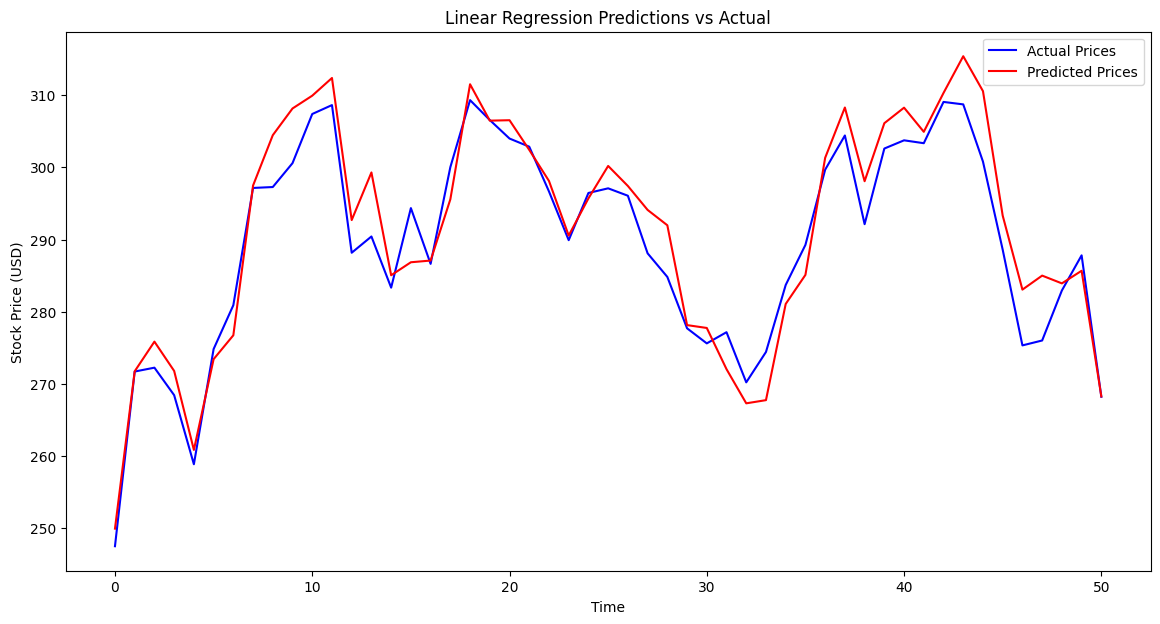

In [100]:
# Train a Linear Regression Model
lr_tweet_model = LinearRegression()
lr_tweet_model.fit(X_train_tweet, y_train_tweet)

# Make predictions on the train and test sets
lr_tweet_train_pred = lr_tweet_model.predict(X_train_tweet)
lr_tweet_test_pred = lr_tweet_model.predict(X_test_tweet)

# Convert y_train and y_test to NumPy arrays before reshaping
lr_tweet_train_actual = scaler_y.inverse_transform(y_train_tweet.reshape(-1, 1))  # Reshaping to 2D for inverse_transform
lr_tweet_test_actual = scaler_y.inverse_transform(y_test_tweet.reshape(-1, 1))    # Reshaping to 2D for inverse_transform
lr_tweet_train_pred_actual = scaler_y.inverse_transform(lr_tweet_train_pred.reshape(-1, 1))
lr_tweet_test_pred_actual = scaler_y.inverse_transform(lr_tweet_test_pred.reshape(-1, 1))

# Evaluate the model using RMSE
lr_tweet_train_rmse = np.sqrt(mean_squared_error(lr_tweet_train_actual, lr_tweet_train_pred_actual))
lr_tweet_test_rmse = np.sqrt(mean_squared_error(lr_tweet_test_actual, lr_tweet_test_pred_actual))

# Evaluate the model using R² score
lr_tweet_train_r2 = r2_score(lr_tweet_train_actual, lr_tweet_train_pred_actual)
lr_tweet_test_r2 = r2_score(lr_tweet_test_actual, lr_tweet_test_pred_actual)

print(f"Train Root Mean Squared Error (RMSE): {lr_tweet_train_rmse:.2f}")
print(f"Test  Root Mean Squared Error (RMSE): {lr_tweet_test_rmse:.2f}")
print(f"Train R² Score: {lr_tweet_train_r2 :.2f}")
print(f"Test  R² Score: {lr_tweet_test_r2:.2f}")

# Visualizing predictions vs actual values for the test set
plt.figure(figsize=(14, 7))
plt.plot(lr_tweet_test_actual, label='Actual Prices', color='blue')
plt.plot(lr_tweet_test_pred_actual, label='Predicted Prices', color='red')
plt.title('Linear Regression Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


In [112]:
from xgboost import XGBRegressor  # Ensure correct import
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Build and train XGB model with preprocessing
def build_and_train_xgb_model_with_preprocessing(stock_tweet_data, start_date, end_date):
    """
    Preprocess the data, build, and train an XGBoost model, and evaluate its performance.

    Parameters:
        stock_tweet_data (pd.DataFrame): The combined stock and tweet data.
        start_date (str): Start date for data selection in 'YYYY-MM-DD' format.
        end_date (str): End date for data selection in 'YYYY-MM-DD' format.

    Returns:
        xgb_model (XGBRegressor): Trained XGBoost model.
        cleared_data (pd.DataFrame): Preprocessed data used for training.
    """
    # Preprocess the data
    X_train, X_test, y_train, y_test, scaler_X, scaler_y, cleared_data = preprocess_stock_tweet_data(
        stock_tweet_data.copy(),
        start_date=start_date,
        end_date=end_date
    )

    # Check if preprocessing returned sufficient data
    if X_train is None or X_test is None or y_train is None or y_test is None:
        print("Data preprocessing failed or insufficient data for model training.")
        return None, None

    # Initialize the XGBoost model
    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)

    # Train the model
    xgb_model.fit(
        X_train,
        y_train.ravel(),  # Flatten the target variable if necessary
        eval_set=[(X_test, y_test)],
        verbose=True
    )

    return xgb_model, cleared_data


[0]	validation_0-rmse:0.09188
[1]	validation_0-rmse:0.08735
[2]	validation_0-rmse:0.08315
[3]	validation_0-rmse:0.07909
[4]	validation_0-rmse:0.07526
[5]	validation_0-rmse:0.07231
[6]	validation_0-rmse:0.06935
[7]	validation_0-rmse:0.06623
[8]	validation_0-rmse:0.06394
[9]	validation_0-rmse:0.06149
[10]	validation_0-rmse:0.05931
[11]	validation_0-rmse:0.05688
[12]	validation_0-rmse:0.05510
[13]	validation_0-rmse:0.05298
[14]	validation_0-rmse:0.05098
[15]	validation_0-rmse:0.04938
[16]	validation_0-rmse:0.04801
[17]	validation_0-rmse:0.04658
[18]	validation_0-rmse:0.04506
[19]	validation_0-rmse:0.04395
[20]	validation_0-rmse:0.04259
[21]	validation_0-rmse:0.04115
[22]	validation_0-rmse:0.03988
[23]	validation_0-rmse:0.03878
[24]	validation_0-rmse:0.03769
[25]	validation_0-rmse:0.03686
[26]	validation_0-rmse:0.03605
[27]	validation_0-rmse:0.03521
[28]	validation_0-rmse:0.03445
[29]	validation_0-rmse:0.03376
[30]	validation_0-rmse:0.03312
[31]	validation_0-rmse:0.03255
[32]	validation_0-

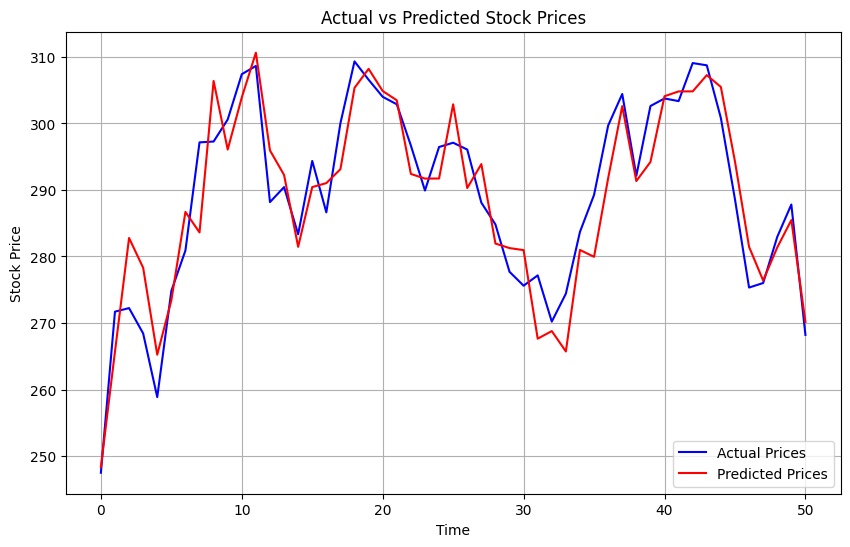

In [113]:
# Make predictions and evaluate performance
def predict_and_evaluate_xgb(xgb_model, X_train, y_train, X_test, y_test, scaler_y):
    """
    Make predictions using the trained XGBoost model and evaluate the performance.

    Parameters:
        xgb_model (XGBRegressor): Trained XGBoost model.
        X_train (np.ndarray): Training data for features.
        y_train (np.ndarray): Training data for target variable.
        X_test (np.ndarray): Test data for features.
        y_test (np.ndarray): Test data for target variable.
        scaler_y (MinMaxScaler): Scaler used for the target variable.

    Returns:
        dict: A dictionary containing evaluation metrics (RMSE, R²) for both train and test sets, and actual vs predicted values.
    """
    # Predict on the train and test sets
    xgb_train_pred_scaled = xgb_model.predict(X_train)
    xgb_test_pred_scaled = xgb_model.predict(X_test)

    # Inverse transform the predictions and target to original scale
    xgb_train_actual = scaler_y.inverse_transform(y_train)
    xgb_test_actual = scaler_y.inverse_transform(y_test)
    xgb_train_pred_actual = scaler_y.inverse_transform(xgb_train_pred_scaled.reshape(-1, 1))
    xgb_test_pred_actual = scaler_y.inverse_transform(xgb_test_pred_scaled.reshape(-1, 1))

    # Calculate RMSE and R² for train and test sets
    xgb_train_rmse = np.sqrt(mean_squared_error(xgb_train_actual, xgb_train_pred_actual))
    xgb_test_rmse = np.sqrt(mean_squared_error(xgb_test_actual, xgb_test_pred_actual))
    xgb_train_r2 = r2_score(xgb_train_actual, xgb_train_pred_actual)
    xgb_test_r2 = r2_score(xgb_test_actual, xgb_test_pred_actual)

    print(f"Train Root Mean Squared Error (RMSE): {xgb_train_rmse:.2f}")
    print(f"Test  Root Mean Squared Error (RMSE): {xgb_test_rmse:.2f}")
    print(f"Train R² Score: {xgb_train_r2:.2f}")
    print(f"Test  R² Score: {xgb_test_r2:.2f}")

    return {
        'Train_RMSE': xgb_train_rmse,
        'Test_RMSE': xgb_test_rmse,
        'Train_R2': xgb_train_r2,
        'Test_R2': xgb_test_r2,
        'y_test_actual': xgb_test_actual,
        'y_test_pred_actual': xgb_test_pred_actual
    }

# Main execution
# Preprocess data and train XGBoost model
xgb_model, cleared_data = build_and_train_xgb_model_with_preprocessing(stock_tweet_data, '2021-09-30', '2022-09-30')

if xgb_model:
    # Predict and evaluate
    xgb_results = predict_and_evaluate_xgb(xgb_model, X_train, y_train, X_test, y_test, scaler_y)

    # Extract metrics and actual/predicted values
    xgb_test_actual = xgb_results['y_test_actual']
    xgb_test_pred_actual = xgb_results['y_test_pred_actual']

    # Display actual vs predicted
    comparison_df = pd.DataFrame({'Actual': xgb_test_actual.ravel(), 'Predicted': xgb_test_pred_actual.ravel()})
    print("\nActual vs Predicted:")
    print(comparison_df.head())

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(xgb_test_actual, label='Actual Prices', color='blue')
    plt.plot(xgb_test_pred_actual, label='Predicted Prices', color='red')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Model training failed.")

In [114]:
def preprocess_stock_tweet_data_lstm(stock_tweet_data, feature_columns, target_column, look_back=60):
    """
    Prepare combined stock and tweet data for the LSTM model by creating sequences.

    Parameters:
        stock_tweet_data (pd.DataFrame): Merged stock and tweet data with features and target column.
        feature_columns (list): Columns used as features.
        target_column (str): Column to be predicted.
        look_back (int): Number of past time steps to use as input.

    Returns:
        X, y: Features and target arrays for training/testing.
        scaler: Fitted MinMaxScaler for inverse transformation.
    """
    # Ensure no missing values in the data
    stock_tweet_data = stock_tweet_data.dropna()

    # Scale features and target column
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(stock_tweet_data[feature_columns + [target_column]])

    # Create sequences for LSTM
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i - look_back:i, :-1])  # Features (all except target)
        y.append(scaled_data[i, -1])  # Target (last column)

    return np.array(X), np.array(y), scaler


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1119 - val_loss: 0.0112
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0429 - val_loss: 0.0098
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0245 - val_loss: 0.0072
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0167 - val_loss: 0.0197
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0158 - val_loss: 0.0079
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0166 - val_loss: 0.0094
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0119 - val_loss: 0.0086
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136 - val_loss: 0.0101
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137 - val_loss: 0.0143
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136 - val_loss: 0.0089
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0129 - val_loss: 0.0092
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - val_l

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train Root Mean Squared Error (RMSE): 14.47
Test  Root Mean Squared Error (RMSE): 24.94
Train R² Score: 0.90
Test  R² Score: -3.74


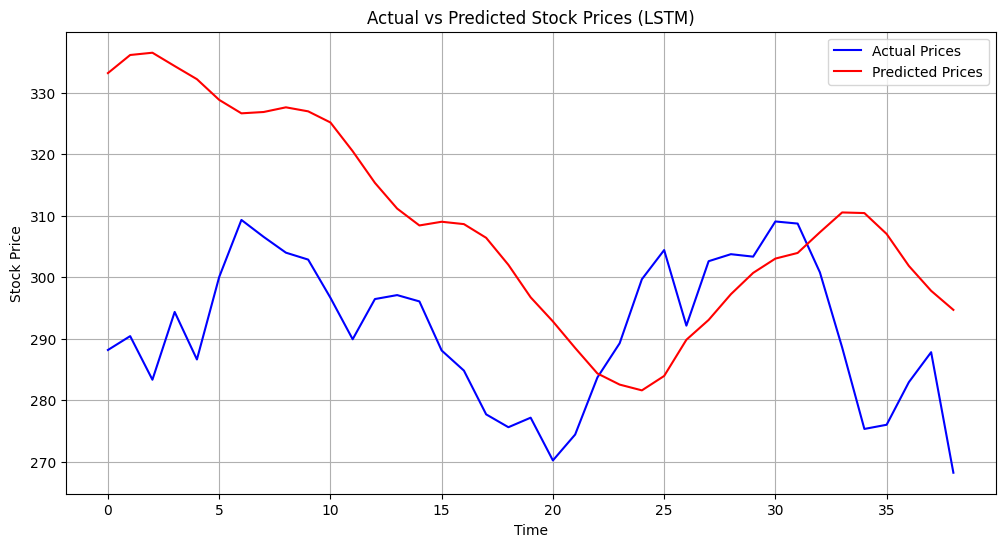

In [115]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np

# Define LSTM model
def build_lstm_model(input_shape):
    """
    Build and compile an LSTM model.

    Parameters:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prepare data
look_back = 60
feature_columns = [col for col in stock_tweet_data.columns if col not in ['Date', 'Close']]
target_column = 'Close'
X, y, scaler = preprocess_stock_tweet_data_lstm(stock_tweet_data, feature_columns, target_column, look_back=look_back)

# Split into train/test sets (80/20)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build and train LSTM model
lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
history = lstm_model.fit(
    X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1
)

# Predictions
lstm_train_pred_scaled = lstm_model.predict(X_train)
lstm_test_pred_scaled = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
lstm_train_actual = scaler.inverse_transform(
    np.hstack((np.zeros((y_train.shape[0], len(feature_columns))), y_train.reshape(-1, 1)))
)[:, -1]
lstm_test_actual = scaler.inverse_transform(
    np.hstack((np.zeros((y_test.shape[0], len(feature_columns))), y_test.reshape(-1, 1)))
)[:, -1]
lstm_train_pred_actual = scaler.inverse_transform(
    np.hstack((np.zeros((lstm_train_pred_scaled.shape[0], len(feature_columns))), lstm_train_pred_scaled))
)[:, -1]
lstm_test_pred_actual = scaler.inverse_transform(
    np.hstack((np.zeros((lstm_test_pred_scaled.shape[0], len(feature_columns))), lstm_test_pred_scaled))
)[:, -1]

# Evaluation metrics
lstm_train_rmse = np.sqrt(mean_squared_error(lstm_train_actual, lstm_train_pred_actual))
lstm_test_rmse = np.sqrt(mean_squared_error(lstm_test_actual, lstm_test_pred_actual))
lstm_train_r2 = r2_score(lstm_train_actual, lstm_train_pred_actual)
lstm_test_r2 = r2_score(lstm_test_actual, lstm_test_pred_actual)

print(f"Train Root Mean Squared Error (RMSE): {lstm_train_rmse:.2f}")
print(f"Test  Root Mean Squared Error (RMSE): {lstm_test_rmse:.2f}")
print(f"Train R² Score: {lstm_train_r2:.2f}")
print(f"Test  R² Score: {lstm_test_r2:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(lstm_test_actual, label='Actual Prices', color='blue')
plt.plot(lstm_test_pred_actual, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices (LSTM)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [120]:
from sklearn.metrics import mean_absolute_error

# Define a dictionary of models and their predictions vs actuals
models = {
    "Linear Regression": (lr_tweet_test_pred_actual.flatten(), lr_tweet_test_actual.flatten()),
    "XGBoost": (xgb_test_pred_actual.flatten(), xgb_test_actual.flatten()),
    "LSTM": (lstm_test_pred_actual.flatten(), lstm_test_actual.flatten())
}

# Prepare results list
results = []

# Evaluate each model
for name, (predictions, true_values) in models.items():
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    r2 = r2_score(true_values, predictions)

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(true_values, predictions)

    results.append([name, mae, rmse, r2, mape])

# Create a DataFrame to display the results
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²', 'MAPE'])

# Display the DataFrame
print(results_df)


               Model        MAE       RMSE        R²      MAPE
0  Linear Regression   3.512294   4.387730  0.904090  1.214724
1            XGBoost   4.472552   5.446687  0.852208  1.555641
2               LSTM  21.332443  24.939170 -3.742800  7.392411


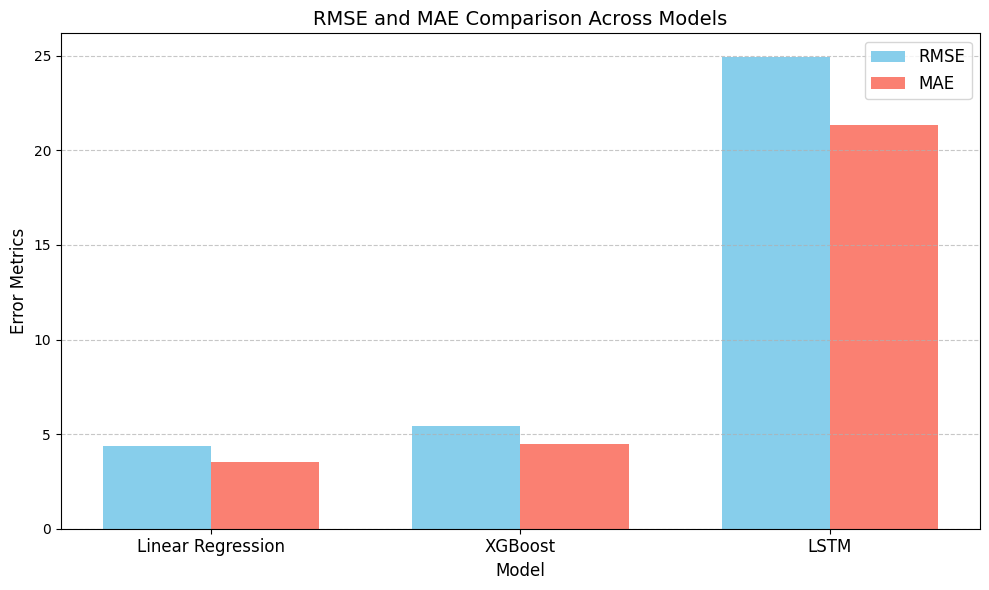

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
#Plotting the Evaluation metrics comparison for the model perfoemance
# Bar Chart for RMSE vs MAE
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(results_df))

# Plot RMSE and MAE side by side
plt.bar(index, results_df['RMSE'], bar_width, label='RMSE', color='skyblue')
plt.bar([i + bar_width for i in index], results_df['MAE'], bar_width, label='MAE', color='salmon')

# Add labels, title, and legend
plt.xlabel('Model', fontsize=12)
plt.ylabel('Error Metrics', fontsize=12)
plt.title('RMSE and MAE Comparison Across Models', fontsize=14)
plt.xticks([i + bar_width / 2 for i in index], results_df['Model'], fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



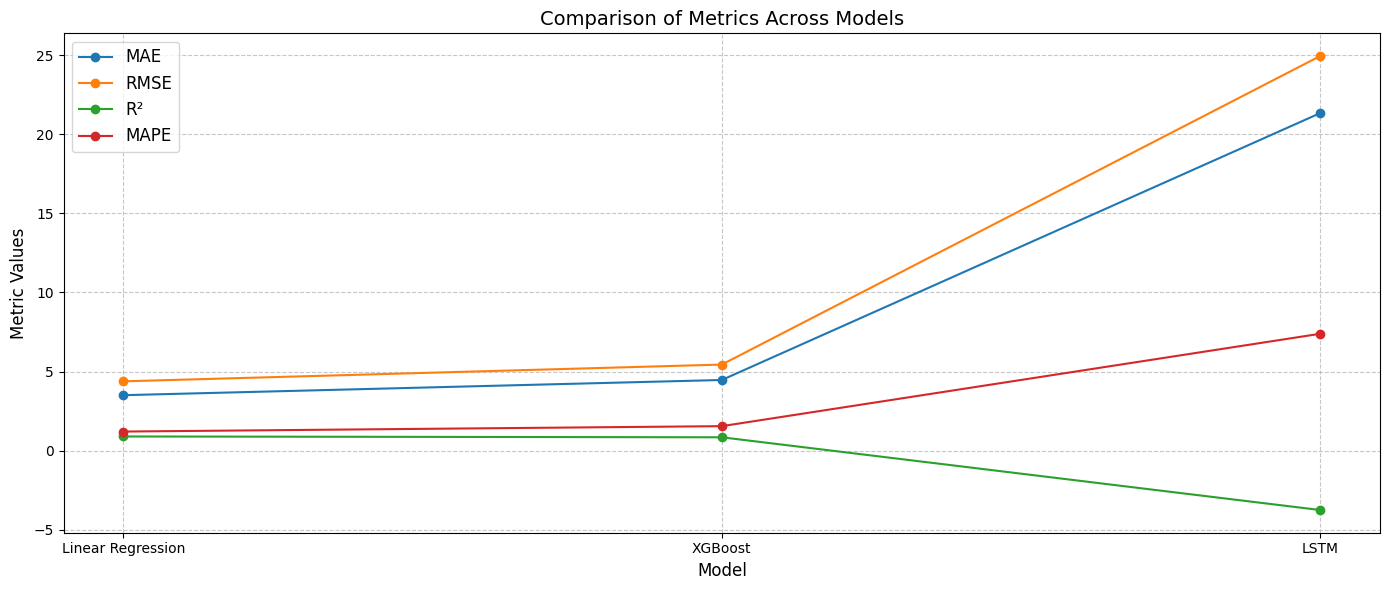

In [124]:
# Line Plot for All Metrics
plt.figure(figsize=(14, 6))
for metric in ['MAE', 'RMSE', 'R²', 'MAPE']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

# Add labels, title, and legend
plt.xlabel('Model', fontsize=12)
plt.ylabel('Metric Values', fontsize=12)
plt.title('Comparison of Metrics Across Models', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [71]:
# Function to train and evaluate models (includes R² calculation)
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# Model Training and Evaluation

# 1. Linear Regression
lr_model = LinearRegression()
lr_r2 = train_evaluate_model(lr_model, X_train, X_test, y_train, y_test)
print(f"Linear Regression R²: {lr_r2:.4f}")  # Format R² to 4 decimal places

Linear Regression R²: 0.9919


In [72]:
# 2. XGBoost (with improved hyperparameter tuning)
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
# You can further optimize these hyperparameters using GridSearchCV or RandomizedSearchCV
xgb_r2 = train_evaluate_model(xgb_model, X_train, X_test, y_train, y_test)
print(f"XGBoost R²: {xgb_r2:.4f}")

XGBoost R²: 0.9685


In [73]:
# Dropping the unnecessaru columns for preprocessing
#stock_tweet_data = data.drop(columns=['total_tweets',	'avg_tweet_length',	'avg_num_hashtags',	'avg_num_mentions'])
#stock_tweet_data.head()

In [74]:
#selected_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'avg_sentiment_score','total_tweets',	'avg_tweet_length',	'avg_num_hashtags',	'avg_num_mentions']

#feat_data = data[selected_features + ['Date']]  # Select relevant features including date


# Convert 'Date' to numeric or drop it
#if 'Date' in data.columns:
 #   data['Date_Num'] = (pd.to_datetime(data['Date']) - pd.to_datetime('2020-01-01')).dt.days
  #  data = data.drop('Date', axis=1)

In [78]:
from sklearn.preprocessing import StandardScaler  # Import StandardScaler
import pandas as pd

# Data Preprocessing
# Convert 'Date' to numeric or drop it
if 'Date' in data.columns:
    # Convert Date to ordinal representation
    data['Date_Num'] = data['Date'].apply(lambda date: date.toordinal())

    # Drop the original 'Date' column
    data = data.drop('Date', axis=1)

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to the updated DataFrame (without 'Date')
scaled_data = scaler.fit_transform(data)

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)

# Train-Test Split
X = scaled_df.drop('Close', axis=1)
y = scaled_df['Close']
X_train_tweet, X_test_tweet, y_train_tweet, y_test_tweet = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [79]:
# Linear Regression Modeling
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train_tweet, y_train_tweet)
linear_predictions = linear_regression_model.predict(X_test_tweet)

In [80]:
# XGboost Modeling
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train_tweet, y_train_tweet)
xgb_predictions = xgb_model.predict(X_test_tweet)

In [81]:
# Data Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)

# Train-Test Split
X = scaled_df.drop('Close', axis=1)
y = scaled_df['Close']
X_train_tweet, X_test_tweet, y_train_tweet, y_test_tweet = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10

# Create sequences AFTER splitting the data
lstm_X_train, lstm_y_train = create_sequences(X_train_tweet.values, y_train_tweet.values, seq_length)  # .values added here
lstm_X_test, lstm_y_test = create_sequences(X_test_tweet.values, y_test_tweet.values, seq_length)  # .values added here

# Reshape input to be [samples, time steps, features] (Correct Reshaping)
lstm_X_train = lstm_X_train.reshape(lstm_X_train.shape[0], lstm_X_train.shape[1], X_train_tweet.shape[1])
lstm_X_test = lstm_X_test.reshape(lstm_X_test.shape[0], lstm_X_test.shape[1], X_test_tweet.shape[1])

# Improved LSTM Model
model = keras.Sequential()
model.add(layers.Input(shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])))  # Define input shape here (time_steps, features)
model.add(layers.LSTM(16, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(32))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

# Training with Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(lstm_X_train, lstm_y_train, epochs=50, batch_size=32, validation_data=(lstm_X_test, lstm_y_test), callbacks=[early_stopping], verbose=0)

# Predictions (Use the correct model object)
lstm_predictions = model.predict(lstm_X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


In [82]:
models = {
    "Linear Regression": (linear_predictions, y_test_tweet),
    "XGBoost": (xgb_predictions, y_test_tweet),
    "LSTM": (lstm_predictions.flatten(), lstm_y_test)
}

results = []

for name, (predictions, true_values) in models.items():
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    r2 = r2_score(true_values, predictions)

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(true_values, predictions)

    results.append([name, mae, rmse, r2, mape]) # Moved inside the loop

results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²', 'MAPE'])
print(results_df)

               Model       MAE      RMSE        R²        MAPE
0  Linear Regression  0.107422  0.128131  0.829028  189.011087
1            XGBoost  0.171932  0.213240  0.526460  563.165270
2               LSTM  0.365407  0.440719 -1.952895  440.297598


In [84]:

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Custom wrapper for XGBRegressor
class WrappedXGBRegressor(XGBRegressor):
    def __sklearn_tags__(self):
        return {
            'allow_nan': False,
            'binary_only': False,
            'multioutput': False,
            'multioutput_only': False,
            'requires_positive_y': False,
            'poor_score': False,
            'requires_fit': True
        }

# Replace XGBRegressor with the wrapped version
xgb = WrappedXGBRegressor(objective='reg:squarederror', random_state=42)

# Parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# GridSearchCV with the wrapped regressor
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='r2', cv=3)

# Fix the .ravel() deprecation warning
grid_search.fit(X_train_tweet, y_train_tweet.to_numpy())

# Retrieve the best model and parameters
best_xgb_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)



AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [85]:
from keras.callbacks import ReduceLROnPlateau

# LSTM Model
model = keras.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(seq_length, lstm_X_train.shape[2])))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(128))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the model
history = model.fit(
    lstm_X_train, lstm_y_train,
    epochs=100,
    batch_size=64,
    validation_data=(lstm_X_test, lstm_y_test),
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)
lstm_predictions = lstm_model.predict(lstm_X_test)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 1.1725 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4372 - val_loss: 0.1216 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3498 - val_loss: 0.1668 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3069 - val_loss: 0.1531 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2369 - val_loss: 0.1440 - learning_rate: 5.0000e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2307 - val_loss: 0.1392 - learning_rate: 5.0000e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


In [86]:
# Model evaluations
models = {
    "Linear Regression": (linear_predictions, y_test_tweet),
    "XGBoost (Improved)": (xgb_predictions, y_test_tweet),
    "LSTM (Improved)": (lstm_predictions.flatten(), lstm_y_test.flatten())
}

results = []
for name, (predictions, true_values) in models.items():
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    r2 = r2_score(true_values, predictions)

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(true_values, predictions)
    results.append([name, mae, rmse, r2, mape])

# Updated results
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²', 'MAPE'])
print(results_df)

                Model       MAE      RMSE        R²        MAPE
0   Linear Regression  0.107422  0.128131  0.829028  189.011087
1  XGBoost (Improved)  0.171932  0.213240  0.526460  563.165270
2     LSTM (Improved)  0.240755  0.301369 -0.380770  126.777044


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ... (Previous code for data loading, cleaning, merging, etc. remains the same)

# Feature Selection and Date Handling
selected_features = ['Open', 'High', 'Low', 'Close', 'SMA_20', 'SMA_50', 'EMA_50', 'EMA_200',
                     'MACD', 'MACD_Histogram', 'RSI', 'ADX', 'Plus_DI', 'Minus_DI',
                     'avg_sentiment_score']

feat_data = stock_tweet_data[selected_features + ['Date']]

feat_data['Date_Num'] = (pd.to_datetime(feat_data['Date']) - pd.to_datetime('2020-01-01')).dt.days
feat_data = feat_data.drop('Date', axis=1)

# Lagged Features (Important!)
for i in range(1, 4):  # Create lags 1 to 3 (adjust as needed)
    feat_data[f'Close_Lag{i}'] = feat_data['Close'].shift(i)
feat_data.dropna(inplace=True)  # Remove NaN values created by shifting

# Data Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(feat_data)
scaled_df = pd.DataFrame(scaled_data, columns=feat_data.columns)

# Train-Test Split (shuffle=False is CRUCIAL for time series)
X = scaled_df.drop('Close', axis=1)
y = scaled_df['Close']
X_train_tweet, X_test_tweet, y_train_tweet, y_test_tweet = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10

# Create sequences AFTER splitting the data
lstm_X_train, lstm_y_train = create_sequences(X_train_tweet.values, y_train_tweet.values, seq_length)
lstm_X_test, lstm_y_test = create_sequences(X_test_tweet.values, y_test_tweet.values, seq_length)

# Reshape input to be [samples, time steps, features]
lstm_X_train = lstm_X_train.reshape(lstm_X_train.shape[0], lstm_X_train.shape[1], X_train_tweet.shape[1])
lstm_X_test = lstm_X_test.reshape(lstm_X_test.shape[0], lstm_X_test.shape[1], X_test_tweet.shape[1])

# --- Model Training ---
# Linear Regression
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train_tweet, y_train_tweet)
linear_predictions = linear_regression_model.predict(X_test_tweet)

# XGBoost with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42), param_grid, cv=3, scoring='r2', verbose=0)
grid_search.fit(X_train_tweet, y_train_tweet)

best_xgb_model = grid_search.best_estimator_
xgb_predictions = best_xgb_model.predict(X_test_tweet)

# LSTM
lstm_model = keras.Sequential()
lstm_model.add(layers.Input(shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])))
lstm_model.add(layers.LSTM(64, return_sequences=True))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.LSTM(32))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(1))

lstm_model.compile(optimizer='adam', loss='mse')

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = lstm_model.fit(lstm_X_train, lstm_y_train, epochs=50, batch_size=32, validation_data=(lstm_X_test, lstm_y_test), callbacks=[early_stopping], verbose=0)

lstm_predictions = lstm_model.predict(lstm_X_test)
lstm_predictions = lstm_predictions.flatten()

# Evaluation and Plotting
models = {
    "Linear Regression": (linear_predictions, y_test_tweet.values),
    "XGBoost": (xgb_predictions, y_test_tweet.values),
    "LSTM": (lstm_predictions, lstm_y_test)
}

results = []

for name, (predictions, true_values) in models.items():
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    r2 = r2_score(true_values, predictions)

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true) else np.inf

    mape = mean_absolute_percentage_error(true_values, predictions)
    results.append([name, mae, rmse, r2, mape])

results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²', 'MAPE'])
print(results_df)

for name, (predictions, true_values) in models.items():
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(f'Actual vs. Predicted Values ({name})')
    plt.xlabel('Time Step')
    plt.ylabel('Scaled Close Value')
    plt.legend()
    plt.show()

# Plotting the loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

KeyError: "['SMA_20', 'SMA_50', 'EMA_50', 'EMA_200', 'MACD', 'MACD_Histogram', 'RSI', 'ADX', 'Plus_DI', 'Minus_DI'] not in index"

In [ ]:
models = {
    "Linear Regression": (linear_predictions, linear_regression_model),
    "XGBoost": (xgb_predictions, xgb_model),
    "LSTM": (lstm_predictions, lstm_model)
}

results = []

for name, (predictions, model) in models.items():
    # ... (metric calculations remain the same)
    results.append([name, mae, rmse, r2, mape])

results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²', 'MAPE'])
print(results_df)

for name, (predictions, model) in models.items():
    # ... (plotting code remains the same)

# Plotting the loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
def create_sequences(data, target_data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        # Use simple slicing for numpy arrays
        x = data[i:(i + seq_length), :]
        y = target_data[i + seq_length]  # Assuming target_data is a 1D array or Series
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Create sequences for LSTM
seq_length = 10

# Full data sequences (used for LSTM training and testing later)
lstm_X, lstm_y = create_sequences(scaled_df.values, scaled_df['Close'], seq_length)

# Train and test sequences
lstm_X_train, lstm_y_train = create_sequences(X_train.reset_index(drop=True).values, X_train['Close'], seq_length)
lstm_X_test, lstm_y_test = create_sequences(X_test.reset_index(drop=True).values, X_test['Close'], seq_length)

# Reshape input to be [samples, time steps, features]
lstm_X_train = lstm_X_train.reshape(lstm_X_train.shape[0], lstm_X_train.shape[1], X_train.shape[1])
lstm_X_test = lstm_X_test.reshape(lstm_X_test.shape[0], lstm_X_test.shape[1], X_test.shape[1])

lstm_model = keras.Sequential()
lstm_model.add(layers.LSTM(64, return_sequences=True, input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.LSTM(32))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(1))

lstm_model.compile(optimizer='adam', loss='mse')

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = lstm_model.fit(lstm_X_train, lstm_y_train, epochs=50, batch_size=32, validation_data=(lstm_X_test, lstm_y_test), callbacks=[early_stopping], verbose=0)

lstm_predictions = lstm_model.predict(lstm_X_test)

In [ ]:
# Feature Engineering and Scaling
feature_columns = stock_tweet_data.columns.difference(['Date', 'Close'])
target_column = 'Close'

# Handle missing values (if any)
data = data.dropna()

# Split features and target
X = stock_tweet_data[feature_columns]
y = stock_tweet_data[target_column]

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scalers to the data
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

In [ ]:
# --- Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

# Evaluate
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))
lr_r2 = r2_score(y_test, lr_test_pred)  # Calculate R² score

print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R²: {lr_r2}")

In [ ]:
# --- XGBoost ---
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Evaluate
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))
xgb_r2 = r2_score(y_test, xgb_test_pred)  # Calculate R² score

print(f"XGBoost RMSE: {xgb_rmse}")
print(f"XGBoost R²: {xgb_r2}")

In [ ]:
# --- LSTM ---
# Reshape data for LSTM (3D input: samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# Predictions
lstm_train_pred = lstm_model.predict(X_train_lstm)
lstm_test_pred = lstm_model.predict(X_test_lstm)

# Evaluate
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_test_pred))
lstm_r2 = r2_score(y_test, lstm_test_pred)  # Calculate R² score

print(f"LSTM RMSE: {lstm_rmse}")
print(f"LSTM R²: {lstm_r2}")

In [ ]:
# --- Results ---
# Inverse transform predictions to original scale
lr_test_pred_actual = scaler_y.inverse_transform(lr_test_pred)
xgb_test_pred_actual = scaler_y.inverse_transform(xgb_test_pred.reshape(-1, 1))
lstm_test_pred_actual = scaler_y.inverse_transform(lstm_test_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

# Plot actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(lr_test_pred_actual, label='Linear Regression Predictions', color='green')
plt.plot(xgb_test_pred_actual, label='XGBoost Predictions', color='orange')
plt.plot(lstm_test_pred_actual, label='LSTM Predictions', color='red')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()